In [0]:
!pip install yahoofinancials 
!pip install pandas_datareader
!pip install mpl_finance
!pip install sklearn

  Created wheel for yahoofinancials: filename=yahoofinancials-1.5-cp36-none-any.whl size=15195 sha256=1b16aa600d89cabb774815b8dda3c69a9ce1720885f46c905a33e05d924f36f1
  Stored in directory: /root/.cache/pip/wheels/42/15/e7/240c5cdc8782b9479ba73404640a3be57bb4053a5c3edd6be5
Successfully built yahoofinancials


In [0]:
import numpy as np
import pandas as pd
import os
import time
import datetime
import pandas_datareader as web
import mpl_finance as mpl
import sqlite3
import sklearn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

sns.set()


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
CNFont = mpl.font_manager.FontProperties(fname='/content/drive/My Drive/AlgoTrading/simhei.ttf')


In [0]:
def get_today():
    today = time.localtime(time.time())
    today_year  = today.tm_year
    today_month = today.tm_mon
    today_date = today.tm_mday
    today_format = datetime.datetime(today_year, today_month, today_date)
    today_format = today_format.strftime('%Y%m%d') #20191001
    return today_format

class GetData(object):
    def __init__(self,Name,Startdate,Enddate,LabelName,Datasource='yahoo'):
        self.Name = Name
        self.Startdate = Startdate
        self.Enddate = Enddate
        self.Datasource  = Datasource
        self.LabelName = LabelName
        New_Startdate_format = time.strptime(self.Startdate,'%Y%m%d')
        New_Enddate_format = time.strptime(self.Enddate,'%Y%m%d')
        New_Startdate = datetime.datetime(New_Startdate_format.tm_year,New_Startdate_format.tm_mon,New_Startdate_format.tm_mday).strftime('%m/%d/%Y')
        New_Enddate = datetime.datetime(New_Enddate_format.tm_year,New_Enddate_format.tm_mon,New_Enddate_format.tm_mday).strftime('%m/%d/%Y')
        self.NewStartdate = New_Startdate
        self.NewEnddate = New_Enddate
    def DownloadData(self):
        DataInformation = web.DataReader(self.Name,self.Datasource,self.NewStartdate,self.NewEnddate)
        Trade_Date_List = []
        for TradeDate in range(len(DataInformation.index)):
            Trade_Date_Format = time.strptime(str(DataInformation.index[TradeDate]), '%Y-%m-%d %H:%M:%S')
            Trade_Date = datetime.datetime(Trade_Date_Format.tm_year, Trade_Date_Format.tm_mon,
                                           Trade_Date_Format.tm_mday).strftime('%Y%m%d')
            Trade_Date_List.append(Trade_Date)
        Index_Trade_Date_List = []
        for TradeDate in range(len(DataInformation.index)):
            Index_Trade_Date_Format = time.strptime(str(DataInformation.index[TradeDate]), '%Y-%m-%d %H:%M:%S')
            Index_Trade_Date = datetime.datetime(Index_Trade_Date_Format.tm_year, Index_Trade_Date_Format.tm_mon,
                                           Index_Trade_Date_Format.tm_mday).strftime('%Y-%m-%d')
            Index_Trade_Date_List.append(Index_Trade_Date)
        DataInformation['IndexTradeDate'] = Index_Trade_Date_List
        DataInformation['TradeDate'] = Trade_Date_List
        DataInformation['Name'] = self.LabelName
        all_columns = DataInformation.columns.tolist()
        all_columns.pop(-1)
        all_columns.insert(0, 'Name')
        all_columns.pop(-1)
        all_columns.insert(1, 'TradeDate')
        all_columns.pop(-1)
        all_columns.insert(2, 'IndexTradeDate')
        DataInformation = DataInformation.reindex(columns = all_columns)
        for i in range(len(DataInformation)):
            DataInformation['TradeDate'][i] = int(DataInformation['TradeDate'][i])
        CurrentFilePath = GetData.SaveData(self,DataInformation)
        print('Data has already been downloaded from %s'%self.Datasource , '!')
        print('Information : \n','Name : %s'%self.Name,'\n','Columns : ',all_columns,'\n','Total index ',len(DataInformation.index),'\n'
              ,'Saved Path in csv: ',CurrentFilePath[0],'\n','Saved Path in excel:',CurrentFilePath[1])
        return DataInformation
    def GetCurrentPath(self):
        CurrentFilePath = os.getcwd()
        return CurrentFilePath
    def SaveData(self,DataInformation):
        CurrentFilePath = GetData.GetCurrentPath(self)
        CurrentFilePath = CurrentFilePath + str(r'/DataBase')
        if not os.path.exists(CurrentFilePath):
            os.makedirs(CurrentFilePath)
        CurrentFilePath_csv = CurrentFilePath + str(r'/Csv')
        if not os.path.exists(CurrentFilePath_csv):
            os.makedirs(CurrentFilePath_csv)
        CurrentFilePath_excel = CurrentFilePath + str(r'/Xlsx')
        if not os.path.exists(CurrentFilePath_excel):
            os.makedirs(CurrentFilePath_excel)
        CurrentFilePath_csv = CurrentFilePath_csv + str(r'/') + str(self.LabelName)
        CurrentFilePath_csv = CurrentFilePath_csv + str(r'.csv')
        CurrentFilePath_excel = CurrentFilePath_excel + str(r'/')+ str(self.LabelName)
        CurrentFilePath_excel = CurrentFilePath_excel + str(r'.xlsx')
        DataInformation.to_csv(CurrentFilePath_csv,encoding='utf_8_sig')
        DataInformation.to_excel(excel_writer=CurrentFilePath_excel, encoding='utf_8_sig')
        return CurrentFilePath_csv,CurrentFilePath_excel
    def ReadDataFromCsv(self,path):
        DataInformation = pd.read_csv(path)
        return DataInformation
    def ReadDataFromExcel(self,path):
        DataInformation = pd.read_excel(path)
        return  DataInformation
    def __str__(self):
        return 'Name : '+str(self.LabelName)+'\n'+'Start Date : '+str(self.NewStartdate)+'\n'+'End Date : '+str(self.NewEnddate)+'\n'+'Data Source : '+str(self.Datasource)

In [0]:

def CreateASQLite3():

  
    CurrentFilePath =os.getcwd()
    CurrentFilePath = CurrentFilePath + str(r'/DataBase')
    if not os.path.exists(CurrentFilePath):
        os.makedirs(CurrentFilePath)
    DatabaseName = 'HKStockDatabase.db'
    DatabaseSavePath = [CurrentFilePath,r'/',DatabaseName]
    DatabaseSavePath = ''.join(DatabaseSavePath)
    con = sqlite3.connect(DatabaseSavePath)
    cur = con.cursor()
    cur.execute("CREATE TABLE IF NOT EXISTS HKStock('Date','Name','TradeDate','IndexTradeDate','High','Low','Open','Close','Volume','Adj_Close' )")
    return DatabaseSavePath

def UpdateToSQLite3(DataInformation,DatabaseSavePath,DataBaseName = 'HKStock'):
    con = sqlite3.connect(DatabaseSavePath)
    Symbol = DataInformation['Name'][0]
    # code = '''delete from HKStock where HKStock.Name = 'AAC' and HKStock.TradeDate = (select max(TradeDate) from HKStock where HKStock.Name = 'AAC' order by HKStock.TradeDate) '''
    CheckingCode = [r'select max(TradeDate) as TradeDate from HKStock where HKStock.Name = ',r"'",Symbol,r"'"]
    CheckingCode = ''.join(CheckingCode)
    CheckingDate = pd.read_sql(CheckingCode,con= con)
    if CheckingDate['TradeDate'][0]:
        NewDataInformation = DataInformation[DataInformation['TradeDate']>CheckingDate['TradeDate'][0]].copy()
        NewDataInformation.rename(columns = {'Adj Close':'Adj_Close'},inplace = True)
        NewDataInformation.to_sql(name=DataBaseName,con=con,if_exists='append',index=False)
    else:
        DataInformation.rename(columns = {'Adj Close':'Adj_Close'},inplace = True)
        DataInformation.to_sql(name=DataBaseName, con=con,if_exists='append',index=False)
    print(Symbol,'Data Uploaded Successfully!')


In [0]:

startdate = '20180101'
enddate = get_today()
#DatabaseSavePath = CreateASQLite3()
SymbolSavePath = r'/content/drive/My Drive/AlgoTrading/HK Target Stock.xlsx'

AllSymbols = pd.read_excel(SymbolSavePath)
print(AllSymbols.head())
t0 = time.time()
for i in range(len(AllSymbols)):
    print(AllSymbols['Symbol'][i])
    Temporary = GetData(AllSymbols['Symbol'][i],Startdate=startdate,Enddate=enddate,LabelName=AllSymbols['Name'][i])
    DataInformation = Temporary.DownloadData()
    UpdateToSQLite3(DataInformation,DatabaseSavePath)
t1 = time.time()-t0
print('Done! Spend%.2f'%t1,'seconds.')

   Unnamed: 0    Name   Symbol
0           0      長和  0001.HK
1           1    中電控股  0002.HK
2           2    中華煤氣  0003.HK
3           3   九龍倉集團  0004.HK
4           4    滙豐控股  0005.HK
0001.HK


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


流式输出内容被截断，只能显示最后 5000 行内容。
 Saved Path in csv:  /content/drive/My Drive/AlgoTrading/DataBase/Csv/ 太古地產.csv 
 Saved Path in excel: /content/drive/My Drive/AlgoTrading/DataBase/Xlsx/ 太古地產.xlsx
 太古地產 Data Uploaded Successfully!
1975.HK
Data has already been downloaded from yahoo !
Information : 
 Name : 1975.HK 
 Columns :  ['Name', 'TradeDate', 'IndexTradeDate', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'] 
 Total index  542 
 Saved Path in csv:  /content/drive/My Drive/AlgoTrading/DataBase/Csv/ 新興印刷.csv 
 Saved Path in excel: /content/drive/My Drive/AlgoTrading/DataBase/Xlsx/ 新興印刷.xlsx
 新興印刷 Data Uploaded Successfully!
1979.HK
Data has already been downloaded from yahoo !
Information : 
 Name : 1979.HK 
 Columns :  ['Name', 'TradeDate', 'IndexTradeDate', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'] 
 Total index  542 
 Saved Path in csv:  /content/drive/My Drive/AlgoTrading/DataBase/Csv/ 天寶集團.csv 
 Saved Path in excel: /content/drive/My Drive/AlgoTrading/DataBase/Xls

KeyError: ignored

In [0]:
DatabaseSavePath = r'/content/drive/My Drive/AlgoTrading/DataBase/HKStockDatabase.db'
con = sqlite3.connect(DatabaseSavePath)
AllDataCode = '''select * from HKStock'''
ALLData = pd.read_sql(AllDataCode,con=con)
DataInformation = pd.DataFrame()
ALLData


,Date,Name,TradeDate,IndexTradeDate,High,Low,Open,Close,Volume,Adj_Close
0,None,長和,20180102,2018-01-02,99.000000,98.099998,98.099998,98.650002,3129165.0,91.547417
1,None,長和,20180103,2018-01-03,99.099998,98.000000,99.099998,98.400002,4186522.0,91.315414
2,None,長和,20180104,2018-01-04,99.349998,98.449997,98.800003,99.099998,4357990.0,91.965012
3,None,長和,20180105,2018-01-05,99.750000,98.800003,99.500000,99.250000,3294493.0,92.104210
4,None,長和,20180108,2018-01-08,99.949997,99.099998,99.949997,99.349998,3454980.0,92.197014
...,...,...,...,...,...,...,...,...,...,...
1038957,None,宏創高科,20200309,2020-03-09,0.079000,0.079000,0.079000,0.079000,0.0,0.079000
1038958,None,宏創高科,20200310,2020-03-10,0.087000,0.087000,0.087000,0.087000,0.0,0.087000
1038959,None,宏創高科,20200311,2020-03-11,0.090000,0.090000,0.090000,0.090000,0.0,0.090000
1038960,None,宏創高科,20200312,2020-03-12,0.086000,0.086000,0.086000,0.086000,0.0,0.086000


In [0]:
NameList = ALLData['Name'].unique()
t0 = time.time()
NewNameList = []
for i,Name in enumerate(NameList):
    Temporary = ALLData[ALLData['Name'].isin([Name])]
    if len(Temporary.index) == len(Temporary['TradeDate'].unique()):
        Temporary.index = Temporary['TradeDate']
        Symbol = ''.join([str(Name), ' Adj_Close'])
        Temporary.rename(columns = {'Adj_Close':Symbol},inplace = True)
        DataInformation  = pd.concat([DataInformation,Temporary[[Symbol]]],axis=1)
        NewNameList.append(Name)
t1 = time.time() - t0
print('Spend %.2f'%t1)
DataInformation

Spend 62.43


,長和 Adj_Close,中電控股 Adj_Close,中華煤氣 Adj_Close,九龍倉集團 Adj_Close,滙豐控股 Adj_Close,電能實業 Adj_Close,凱富能源 Adj_Close,電訊盈科 Adj_Close,九號通運 Adj_Close,恒隆集團 Adj_Close,恒生銀行 Adj_Close,恒基地產 Adj_Close,希慎興業 Adj_Close,盈信控股 Adj_Close,新鴻基地產 Adj_Close,新世界發展 Adj_Close,東方報業 Adj_Close,太古股份公司A Adj_Close,會德豐 Adj_Close,大中華地產 Adj_Close,茂盛控股 Adj_Close,東亞銀行 Adj_Close,寶威控股 Adj_Close,其士國際 Adj_Close,中華汽車 Adj_Close,銀河娛樂 Adj_Close,天安中國 Adj_Close,達力集團 Adj_Close,萬隆控股集團 Adj_Close,航天控股 Adj_Close,港通控股 Adj_Close,亞投金融集團 Adj_Close,九龍建業 Adj_Close,遠東發展 Adj_Close,遠東控股國際 Adj_Close,遠東酒店 Adj_Close,第一拖拉機 Adj_Close,北大荒產業 Adj_Close,金山工業 Adj_Close,鷹君集團 Adj_Close,...,尚捷集團 Adj_Close,中國糖果 Adj_Close,同仁資源 Adj_Close,永駿國際 Adj_Close,駿傑集團控股 Adj_Close,泰達生物 Adj_Close,鴻偉亞洲 Adj_Close,漢華專業服務 Adj_Close,樂亞國際 Adj_Close,建禹集團 Adj_Close,東北虎藥業 Adj_Close,新濠環彩 Adj_Close,中國萬桐園 Adj_Close,修身堂 Adj_Close,寶聯控股 Adj_Close,匯創控股 Adj_Close,凱順能源 Adj_Close,交大慧谷 Adj_Close,神通電信服務 Adj_Close,浙江永隆實業 Adj_Close,惟膳 Adj_Close,第一信用控股 Adj_Close,聯旺集團 Adj_Close,毅高國際控股 Adj_Close,PF Group Holdings Adj_Close,比高集團 Adj_Close,壹照明 Adj_Close,中國醫療 Adj_Close,中昱科技 Adj_Close,海天天線 Adj_Close,國藝娛樂 Adj_Close,Future Data Adj_Close,節能元件 Adj_Close,Classified Group Adj_Close,賽迪顧問 Adj_Close,寶德科技集團 Adj_Close,華星控股 Adj_Close,惠陶集團 Adj_Close,首都金融 Adj_Close,宏創高科 Adj_Close
TradeDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20180102,91.547417,72.417458,12.113365,25.114000,72.029709,59.809338,0.94,3.978034,0.265,27.110270,175.523849,38.576633,37.378078,0.812166,119.673157,11.196664,0.859981,68.246765,53.610329,0.189,0.280,31.522160,0.340,11.956599,83.752579,59.148270,5.006145,8.047919,0.285,0.887930,11.870127,1.060,7.098741,4.097378,0.660,0.395,3.43,0.370,0.803013,38.738419,...,0.437419,NaN,0.624,1.980,0.270339,0.300,0.335,0.460,0.044,2.42,NaN,0.204,0.280,0.456,0.245882,0.172,0.268080,0.390,0.395,0.255,0.052,0.108,0.300,0.209,0.121667,0.288,0.212,0.245,0.280,7.69,0.410,0.296478,0.200,1.800,0.288810,2.61,0.740,1.140,0.111,0.137
20180103,91.315414,71.693733,12.176688,25.614460,71.719604,60.261757,0.93,3.986778,0.260,27.203432,175.162857,38.428822,37.512375,0.812166,119.218475,11.196664,0.859981,68.810013,53.657604,0.188,0.280,31.197186,0.350,11.735862,83.752579,59.492157,5.051906,8.234853,0.280,0.897376,11.963738,1.060,7.090224,3.983074,0.710,0.410,3.46,0.365,0.793888,38.879456,...,0.432716,NaN,0.720,1.880,0.270339,0.300,0.335,0.450,0.044,2.48,NaN,0.203,0.280,0.464,0.245882,0.215,0.268080,0.390,0.385,0.242,0.044,0.108,0.305,0.209,0.113333,0.296,0.210,0.260,0.285,7.50,0.405,0.296478,0.192,1.800,0.288810,2.61,0.730,1.160,0.105,0.137
20180104,91.965012,71.603264,12.240107,27.843782,71.320923,60.216515,0.93,4.030492,0.260,27.855568,174.711655,38.798313,38.273365,0.840497,120.491585,11.309953,0.841683,68.997765,55.501350,0.188,0.280,31.661430,0.350,11.754257,83.669571,59.197399,5.088513,8.264368,0.280,0.916268,11.907571,1.040,7.081698,4.000659,0.730,0.400,3.45,0.355,0.821263,38.550369,...,0.432716,NaN,0.728,1.880,0.270339,0.320,0.305,0.450,0.044,2.30,NaN,0.186,0.285,0.496,0.245882,0.205,0.287937,0.400,0.375,0.242,0.046,0.108,0.315,0.211,0.115000,0.304,0.220,0.275,0.275,7.75,0.400,0.296478,0.193,1.670,0.288810,2.61,0.740,1.160,0.105,0.136
20180105,92.104210,72.146057,12.271720,28.025766,71.586716,60.216515,0.98,4.030492,0.265,28.321381,175.072617,39.500439,39.079117,0.821609,122.219376,11.706462,0.850832,70.828316,56.115925,0.186,0.280,31.475737,0.345,11.938204,83.669571,58.263996,5.180033,8.264368,0.280,0.887930,11.888848,1.030,7.158401,4.000659,0.720,0.410,3.48,0.360,0.821263,39.161537,...,0.423309,NaN,0.736,1.850,0.275254,0.320,0.305,0.460,0.044,2.30,NaN,0.187,0.285,0.464,0.245882,0.207,0.273044,0.400,0.370,0.242,0.046,0.108,0.310,0.218,0.118333,0.304,0.220,0.270,0.275,7.52,0.395,0.301184,0.196,1.670,0.297836,3.09,0.730,1.140,0.110,0.136
20180108,92.197014,71.919884,12.271720,28.435236,71.320923,60.397472,0.95,4.021749,0.260,28.367964,173.358002,39.389561,39.481995,1.019929,122.128441,11.630937,0.841683,72.940491,56.541405,0.1

In [0]:
NewColumns = DataInformation.columns.to_list()
NewColumns


[' 長和 Adj_Close',
 ' 中電控股 Adj_Close',
 ' 中華煤氣 Adj_Close',
 ' 九龍倉集團 Adj_Close',
 ' 滙豐控股 Adj_Close',
 ' 電能實業 Adj_Close',
 ' 凱富能源 Adj_Close',
 ' 電訊盈科 Adj_Close',
 ' 九號通運 Adj_Close',
 ' 恒隆集團 Adj_Close',
 ' 恒生銀行 Adj_Close',
 ' 恒基地產 Adj_Close',
 ' 希慎興業 Adj_Close',
 ' 盈信控股 Adj_Close',
 ' 新鴻基地產 Adj_Close',
 ' 新世界發展 Adj_Close',
 ' 東方報業 Adj_Close',
 ' 太古股份公司A Adj_Close',
 ' 會德豐 Adj_Close',
 ' 大中華地產 Adj_Close',
 ' 茂盛控股 Adj_Close',
 ' 東亞銀行 Adj_Close',
 ' 寶威控股 Adj_Close',
 ' 其士國際 Adj_Close',
 ' 中華汽車 Adj_Close',
 ' 銀河娛樂 Adj_Close',
 ' 天安中國 Adj_Close',
 ' 達力集團 Adj_Close',
 ' 萬隆控股集團 Adj_Close',
 ' 航天控股 Adj_Close',
 ' 港通控股 Adj_Close',
 ' 亞投金融集團 Adj_Close',
 ' 九龍建業 Adj_Close',
 ' 遠東發展 Adj_Close',
 ' 遠東控股國際 Adj_Close',
 ' 遠東酒店 Adj_Close',
 ' 第一拖拉機 Adj_Close',
 ' 北大荒產業 Adj_Close',
 ' 金山工業 Adj_Close',
 ' 鷹君集團 Adj_Close',
 ' 東北電氣 Adj_Close',
 ' 卜蜂國際 Adj_Close',
 ' 香港飛機工程 Adj_Close',
 ' 大酒店 Adj_Close',
 ' 科聯系統 Adj_Close',
 ' 合興集團 Adj_Close',
 ' 中國汽車內飾 Adj_Close',
 ' 香港小輪 Adj_Close',
 ' 海港企業 Adj_Close',
 ' 大快

In [0]:
DataInformation = DataInformation[NewColumns].T.drop_duplicates().T
DataInformation

,長和 Adj_Close,中電控股 Adj_Close,中華煤氣 Adj_Close,九龍倉集團 Adj_Close,滙豐控股 Adj_Close,電能實業 Adj_Close,凱富能源 Adj_Close,電訊盈科 Adj_Close,九號通運 Adj_Close,恒隆集團 Adj_Close,恒生銀行 Adj_Close,恒基地產 Adj_Close,希慎興業 Adj_Close,盈信控股 Adj_Close,新鴻基地產 Adj_Close,新世界發展 Adj_Close,東方報業 Adj_Close,太古股份公司A Adj_Close,會德豐 Adj_Close,大中華地產 Adj_Close,茂盛控股 Adj_Close,東亞銀行 Adj_Close,寶威控股 Adj_Close,其士國際 Adj_Close,中華汽車 Adj_Close,銀河娛樂 Adj_Close,天安中國 Adj_Close,達力集團 Adj_Close,萬隆控股集團 Adj_Close,航天控股 Adj_Close,港通控股 Adj_Close,亞投金融集團 Adj_Close,九龍建業 Adj_Close,遠東發展 Adj_Close,遠東控股國際 Adj_Close,遠東酒店 Adj_Close,第一拖拉機 Adj_Close,北大荒產業 Adj_Close,金山工業 Adj_Close,鷹君集團 Adj_Close,...,尚捷集團 Adj_Close,中國糖果 Adj_Close,同仁資源 Adj_Close,永駿國際 Adj_Close,駿傑集團控股 Adj_Close,泰達生物 Adj_Close,鴻偉亞洲 Adj_Close,漢華專業服務 Adj_Close,樂亞國際 Adj_Close,建禹集團 Adj_Close,東北虎藥業 Adj_Close,新濠環彩 Adj_Close,中國萬桐園 Adj_Close,修身堂 Adj_Close,寶聯控股 Adj_Close,匯創控股 Adj_Close,凱順能源 Adj_Close,交大慧谷 Adj_Close,神通電信服務 Adj_Close,浙江永隆實業 Adj_Close,惟膳 Adj_Close,第一信用控股 Adj_Close,聯旺集團 Adj_Close,毅高國際控股 Adj_Close,PF Group Holdings Adj_Close,比高集團 Adj_Close,壹照明 Adj_Close,中國醫療 Adj_Close,中昱科技 Adj_Close,海天天線 Adj_Close,國藝娛樂 Adj_Close,Future Data Adj_Close,節能元件 Adj_Close,Classified Group Adj_Close,賽迪顧問 Adj_Close,寶德科技集團 Adj_Close,華星控股 Adj_Close,惠陶集團 Adj_Close,首都金融 Adj_Close,宏創高科 Adj_Close
TradeDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20180102,91.547417,72.417458,12.113365,25.114000,72.029709,59.809338,0.94,3.978034,0.265,27.110270,175.523849,38.576633,37.378078,0.812166,119.673157,11.196664,0.859981,68.246765,53.610329,0.189,0.280,31.522160,0.340,11.956599,83.752579,59.148270,5.006145,8.047919,0.285,0.887930,11.870127,1.060,7.098741,4.097378,0.660,0.395,3.43,0.370,0.803013,38.738419,...,0.437419,NaN,0.624,1.980,0.270339,0.300,0.335,0.460,0.044,2.42,NaN,0.204,0.280,0.456,0.245882,0.172,0.268080,0.390,0.395,0.255,0.052,0.108,0.300,0.209,0.121667,0.288,0.212,0.245,0.280,7.69,0.410,0.296478,0.200,1.800,0.288810,2.61,0.740,1.140,0.111,0.137
20180103,91.315414,71.693733,12.176688,25.614460,71.719604,60.261757,0.93,3.986778,0.260,27.203432,175.162857,38.428822,37.512375,0.812166,119.218475,11.196664,0.859981,68.810013,53.657604,0.188,0.280,31.197186,0.350,11.735862,83.752579,59.492157,5.051906,8.234853,0.280,0.897376,11.963738,1.060,7.090224,3.983074,0.710,0.410,3.46,0.365,0.793888,38.879456,...,0.432716,NaN,0.720,1.880,0.270339,0.300,0.335,0.450,0.044,2.48,NaN,0.203,0.280,0.464,0.245882,0.215,0.268080,0.390,0.385,0.242,0.044,0.108,0.305,0.209,0.113333,0.296,0.210,0.260,0.285,7.50,0.405,0.296478,0.192,1.800,0.288810,2.61,0.730,1.160,0.105,0.137
20180104,91.965012,71.603264,12.240107,27.843782,71.320923,60.216515,0.93,4.030492,0.260,27.855568,174.711655,38.798313,38.273365,0.840497,120.491585,11.309953,0.841683,68.997765,55.501350,0.188,0.280,31.661430,0.350,11.754257,83.669571,59.197399,5.088513,8.264368,0.280,0.916268,11.907571,1.040,7.081698,4.000659,0.730,0.400,3.45,0.355,0.821263,38.550369,...,0.432716,NaN,0.728,1.880,0.270339,0.320,0.305,0.450,0.044,2.30,NaN,0.186,0.285,0.496,0.245882,0.205,0.287937,0.400,0.375,0.242,0.046,0.108,0.315,0.211,0.115000,0.304,0.220,0.275,0.275,7.75,0.400,0.296478,0.193,1.670,0.288810,2.61,0.740,1.160,0.105,0.136
20180105,92.104210,72.146057,12.271720,28.025766,71.586716,60.216515,0.98,4.030492,0.265,28.321381,175.072617,39.500439,39.079117,0.821609,122.219376,11.706462,0.850832,70.828316,56.115925,0.186,0.280,31.475737,0.345,11.938204,83.669571,58.263996,5.180033,8.264368,0.280,0.887930,11.888848,1.030,7.158401,4.000659,0.720,0.410,3.48,0.360,0.821263,39.161537,...,0.423309,NaN,0.736,1.850,0.275254,0.320,0.305,0.460,0.044,2.30,NaN,0.187,0.285,0.464,0.245882,0.207,0.273044,0.400,0.370,0.242,0.046,0.108,0.310,0.218,0.118333,0.304,0.220,0.270,0.275,7.52,0.395,0.301184,0.196,1.670,0.297836,3.09,0.730,1.140,0.110,0.136
20180108,92.197014,71.919884,12.271720,28.435236,71.320923,60.397472,0.95,4.021749,0.260,28.367964,173.358002,39.389561,39.481995,1.019929,122.128441,11.630937,0.841683,72.940491,56.541405,0.1

In [0]:
New_DataInformation = DataInformation.copy()
New_DataInformation.reset_index(inplace = True)

del New_DataInformation['TradeDate']



In [0]:
New_DataInformation.describe()
New_Filter_DataInformation = New_DataInformation.copy()
Filter_Name_List = New_DataInformation.columns.to_list()
for i in Filter_Name_List:
  num = New_Filter_DataInformation[i].isna().sum()
  if New_Filter_DataInformation[i].mean() <= 20 or num >= len(New_Filter_DataInformation)/2:
    del New_Filter_DataInformation[i]
New_Filter_DataInformation



,長和 Adj_Close,中電控股 Adj_Close,九龍倉集團 Adj_Close,滙豐控股 Adj_Close,電能實業 Adj_Close,恒隆集團 Adj_Close,恒生銀行 Adj_Close,恒基地產 Adj_Close,希慎興業 Adj_Close,新鴻基地產 Adj_Close,太古股份公司A Adj_Close,會德豐 Adj_Close,東亞銀行 Adj_Close,中華汽車 Adj_Close,銀河娛樂 Adj_Close,鷹君集團 Adj_Close,大快活 Adj_Close,國浩集團 Adj_Close,載通 Adj_Close,港鐵公司 Adj_Close,旭光高新材料 Adj_Close,凱聯國際 Adj_Close,建滔化工集團 Adj_Close,萬邦投資 Adj_Close,青島啤酒 Adj_Close,南洋集團 Adj_Close,尖沙咀置業 Adj_Close,永安國際 Adj_Close,華潤啤酒 Adj_Close,偉易達 Adj_Close,東方海外國際 Adj_Close,維他奶國際 Adj_Close,聯合集團 Adj_Close,華君控股 Adj_Close,中國燃氣 Adj_Close,香港交易所 Adj_Close,北京控股 Adj_Close,敏實集團 Adj_Close,大新金融 Adj_Close,ASM太平洋 Adj_Close,...,H&H國際控股 Adj_Close,長實地產 Adj_Close,海爾電器 Adj_Close,華潤燃氣 Adj_Close,比亞迪股份 Adj_Close,友邦保險 Adj_Close,新華人壽 Adj_Close,麗珠集團 Adj_Close,東陽光藥 Adj_Close,頤海國際 Adj_Close,春立醫療 Adj_Close,新秀麗 Adj_Close,普拉達 Adj_Close,融創中國 Adj_Close,金沙中國 Adj_Close,太古地產 Adj_Close,瑞聲科技 Adj_Close,安踏體育 Adj_Close,溫州康寧醫院 Adj_Close,復星醫藥 Adj_Close,萬科企業 Adj_Close,藥明生物科技 Adj_Close,申洲國際 Adj_Close,中國平安 Adj_Close,蒙牛乳業 Adj_Close,保誠 Adj_Close,舜宇光學科技 Adj_Close,中銀香港 Adj_Close,中銀航空租賃 Adj_Close,中國太保 Adj_Close,新奧能源 Adj_Close,渣打集團 Adj_Close,中國恆大集團 Adj_Close,聯想控股 Adj_Close,福耀玻璃 Adj_Close,中車時代電氣 Adj_Close,招商銀行 Adj_Close,眾安保險 Adj_Close,昊海生物科技 Adj_Close,長飛光纖光纜 Adj_Close
0,91.547417,72.417458,25.114000,72.029709,59.809338,27.110270,175.523849,38.576633,37.378078,119.673157,68.246765,53.610329,31.522160,83.752579,59.148270,38.738419,29.169001,94.042206,22.504856,43.555519,50.0,22.005005,38.312260,174.802124,39.493793,48.348782,24.026804,25.933945,27.524258,88.452385,57.387409,19.846249,41.475544,32.00,20.916759,234.155396,44.377209,45.198860,47.366707,102.832588,...,50.827564,64.857613,21.566185,26.925425,69.057533,65.376160,53.479271,32.252987,25.375565,7.885725,6.128418,34.890835,28.175362,34.509113,34.866322,23.969072,142.027252,34.157028,44.601357,47.601570,30.331547,44.099998,74.155106,80.893616,22.712292,198.857208,107.474831,36.712597,38.119015,35.850861,55.799076,80.221924,24.861292,28.439705,31.411318,49.655159,30.334574,70.300003,37.043644,35.800785
1,91.315414,71.693733,25.614460,71.719604,60.261757,27.203432,175.162857,38.428822,37.512375,119.218475,68.810013,53.657604,31.197186,83.752579,59.492157,38.879456,29.442034,94.134483,22.414833,44.031013,50.0,22.184637,38.853138,174.802124,39.542667,48.348782,24.026804,26.027567,27.573763,87.419876,57.159378,19.651199,41.475544,34.00,21.207266,233.219513,44.661377,45.388176,48.112644,104.910019,...,49.443157,64.951752,21.517612,26.492695,70.594337,65.811035,52.761105,32.940315,25.748734,8.024244,6.137919,34.702995,29.469639,34.270462,35.086998,24.063625,144.587158,34.496178,42.916416,47.893604,30.198904,44.450001,75.217232,79.751587,23.107288,199.056076,107.868874,36.528572,37.843460,36.224304,54.731617,80.075783,25.037613,28.003660,30.909100,50.969563,30.897194,72.400002,38.021049,36.947941
2,91.965012,71.603264,27.843782,71.320923,60.216515,27.855568,174.711655,38.798313,38.273365,120.491585,68.997765,55.501350,31.661430,83.669571,59.197399,38.550369,29.897089,94.503647,22.324816,44.173660,50.0,22.184637,37.636162,175.270752,41.106777,48.641808,24.026804,26.027567,27.722273,86.817566,57.235390,19.651199,41.024727,35.50,21.594614,238.273224,44.235126,46.287422,49.790989,103.682457,...,49.344273,65.092941,21.857620,26.781185,69.999443,65.714386,53.766537,33.839153,28.034399,8.053927,6.080911,33.529011,29.419859,33.984074,35.131130,24.394558,142.690948,34.641525,44.650913,49.256432,30.508410,48.000000,74.010269,79.799164,22.169170,197.862930,105.406113,36.390556,38.027168,36.411026,53.906757,80.562866,24.684971,28.197458,31.274347,51.505058,30.990963,74.199997,39.878117,37.091331
3,92.104210,72.146057,28.025766,71.586716,60.216515,28.321381,175.072617,39.500439,39.079117,122.219376,70.828316,56.115925,31.475737,83.669571,58.263996,39.161537,29.942596,95.703400,22.279806,43.983467,50.0,22.454086,37.681240,175.739410,45.554718,48.641808,24.026804,26.214819,30.593510,87.850082,57.235390,19.797485,40.934559,37.50,21.400942,236.963013,44.0

In [0]:
CorrelationData = New_Filter_DataInformation.corr()
CorrelationData

,長和 Adj_Close,中電控股 Adj_Close,九龍倉集團 Adj_Close,滙豐控股 Adj_Close,電能實業 Adj_Close,恒隆集團 Adj_Close,恒生銀行 Adj_Close,恒基地產 Adj_Close,希慎興業 Adj_Close,新鴻基地產 Adj_Close,太古股份公司A Adj_Close,會德豐 Adj_Close,東亞銀行 Adj_Close,中華汽車 Adj_Close,銀河娛樂 Adj_Close,鷹君集團 Adj_Close,大快活 Adj_Close,國浩集團 Adj_Close,載通 Adj_Close,港鐵公司 Adj_Close,旭光高新材料 Adj_Close,凱聯國際 Adj_Close,建滔化工集團 Adj_Close,萬邦投資 Adj_Close,青島啤酒 Adj_Close,南洋集團 Adj_Close,尖沙咀置業 Adj_Close,永安國際 Adj_Close,華潤啤酒 Adj_Close,偉易達 Adj_Close,東方海外國際 Adj_Close,維他奶國際 Adj_Close,聯合集團 Adj_Close,華君控股 Adj_Close,中國燃氣 Adj_Close,香港交易所 Adj_Close,北京控股 Adj_Close,敏實集團 Adj_Close,大新金融 Adj_Close,ASM太平洋 Adj_Close,...,H&H國際控股 Adj_Close,長實地產 Adj_Close,海爾電器 Adj_Close,華潤燃氣 Adj_Close,比亞迪股份 Adj_Close,友邦保險 Adj_Close,新華人壽 Adj_Close,麗珠集團 Adj_Close,東陽光藥 Adj_Close,頤海國際 Adj_Close,春立醫療 Adj_Close,新秀麗 Adj_Close,普拉達 Adj_Close,融創中國 Adj_Close,金沙中國 Adj_Close,太古地產 Adj_Close,瑞聲科技 Adj_Close,安踏體育 Adj_Close,溫州康寧醫院 Adj_Close,復星醫藥 Adj_Close,萬科企業 Adj_Close,藥明生物科技 Adj_Close,申洲國際 Adj_Close,中國平安 Adj_Close,蒙牛乳業 Adj_Close,保誠 Adj_Close,舜宇光學科技 Adj_Close,中銀香港 Adj_Close,中銀航空租賃 Adj_Close,中國太保 Adj_Close,新奧能源 Adj_Close,渣打集團 Adj_Close,中國恆大集團 Adj_Close,聯想控股 Adj_Close,福耀玻璃 Adj_Close,中車時代電氣 Adj_Close,招商銀行 Adj_Close,眾安保險 Adj_Close,昊海生物科技 Adj_Close,長飛光纖光纜 Adj_Close
長和 Adj_Close,1.000000,-0.380130,0.867491,0.908240,0.336950,0.808434,0.432304,0.035072,0.708618,0.192992,-0.007632,0.432477,0.865716,-0.624754,0.660242,0.824483,0.819976,-0.474524,0.331070,-0.380272,NaN,0.684831,0.861412,-0.429258,-0.226232,0.247016,-0.633936,0.775469,-0.456945,0.825982,0.757347,-0.656315,0.581907,0.845691,-0.503885,0.090865,0.489870,0.811484,0.879899,0.178271,...,0.705941,0.724514,0.520598,-0.748831,0.787380,-0.556326,0.700423,0.575429,-0.246264,-0.808890,-0.656735,0.913407,0.631090,-0.329617,0.328069,0.147159,0.834904,-0.637097,0.628996,0.848127,0.148611,-0.514605,-0.737270,-0.373425,-0.561349,0.905723,0.193680,0.909678,-0.793669,0.603789,-0.725963,0.723215,0.669843,0.916658,0.869970,0.599051,-0.480171,0.840307,0.388992,0.855854
中電控股 Adj_Close,-0.380130,1.000000,-0.366731,-0.445423,-0.569352,-0.427384,0.390115,-0.014981,0.037322,0.161309,0.731579,-0.259970,-0.265607,-0.008452,-0.592610,-0.052623,-0.161266,0.153208,0.096978,0.201577,NaN,-0.217777,-0.565749,0.529808,-0.341981,0.401939,0.639505,-0.026458,-0.186821,-0.578635,-0.428599,0.625193,0.099881,-0.674856,-0.056494,-0.198547,0.075832,-0.701450,-0.174823,-0.678338,...,-0.120730,-0.202964,-0.557138,0.341619,-0.488177,0.253213,-0.368127,-0.758713,-0.283111,0.231728,0.003666,-0.385888,-0.418966,-0.073687,-0.432147,0.632538,-0.703919,-0.023864,0.167619,-0.632980,-0.455171,0.087273,0.450265,-0.111285,-0.068665,-0.431176,-0.606922,-0.299457,0.420023,-0.684765,0.273800,-0.681984,0.143589,-0.285508,-0.324280,0.248603,0.068965,-0.708458,0.203574,-0.396968
九龍倉集團 Adj_Close,0.867491,-0.366731,1.000000,0.899195,0.354970,0.885154,0.341866,0.203162,0.743356,0.424978,0.034063,0.613506,0.823823,-0.509317,0.745305,0.786514,0.774565,-0.529491,0.529274,-0.226066,NaN,0.719151,0.898181,-0.320181,-0.119528,0.328718,-0.582843,0.747311,-0.394372,0.724638,0.846926,-0.546471,0.620816,0.793825,-0.370900,0.298994,0.482447,0.789573,0.787380,0.276084,...,0.731630,0.824957,0.678779,-0.709241,0.735321,-0.394331,0.656272,0.658439,-0.106910,-0.731614,-0.577625,0.830848,0.546380,-0.149690,0.495427,0.204827,0.798127,-0.536801,0.561400,0.840542,0.274678,-0.390955,-0.673095,-0.331213,-0.442348,0.859007,0.288759,0.834837,-0.751115,0.560591,-0.585906,0.755914,0.640455,0.808558,0.899881,0.556414,-0.379132,0.841278,0.322363,0.877372
滙豐控股 Adj_Close,0.908240,-0.445423,0.899195,1.000000,0.306972,0.805684,0.460896,0.182205,0.785268,0.306675,0.027388,0.513165,0.860895,-0.599733,0.723069,0.813156,0.836246,-0.497402,0.521000,-0.213338,NaN,0.767116,0.825990,-0.304576,-0.033096,0.340809,-0.564943,0.782014,-0.345494,0.726995,0.823317,-0.548685,0.642907,0.838686,-0.327043,0.155254,0.440945,0.765325,0.849503,0.239753,...,0.760964,0.786687,0.584038,-0.715051,0.711096,-0.448481,0.671064,0.597262,-0.166471,-

In [0]:
result = np.where(((CorrelationData>=0.94)&(CorrelationData <1)))
result

(array([ 12,  12,  15,  15,  16,  27,  31,  33,  33,  33,  37,  38,  38,
         48,  48,  48,  50,  56,  62,  74,  79,  79,  79,  79,  82,  82,
         82,  86,  88,  90,  96,  96,  96,  99, 100, 100]),
 array([ 38,  96,  16,  27,  15,  15,  50,  48,  79,  82, 100,  12,  96,
         33,  79,  82,  31,  62,  56,  96,  33,  48,  82, 100,  33,  48,
         79,  99,  90,  88,  12,  38,  74,  86,  37,  79]))

In [0]:
Index_Name = CorrelationData.index.to_list()
Columns_Name = CorrelationData.columns.to_list()


 東亞銀行 Adj_Close
 大新金融 Adj_Close
 東亞銀行 Adj_Close
 聯想控股 Adj_Close
 鷹君集團 Adj_Close
 大快活 Adj_Close
 鷹君集團 Adj_Close
 永安國際 Adj_Close
 大快活 Adj_Close
 鷹君集團 Adj_Close
 永安國際 Adj_Close
 鷹君集團 Adj_Close
 維他奶國際 Adj_Close
 領展房產基金 Adj_Close
 華君控股 Adj_Close
 閱文集團 Adj_Close
 華君控股 Adj_Close
 瑞聲科技 Adj_Close
 華君控股 Adj_Close
 復星醫藥 Adj_Close
 敏實集團 Adj_Close
 眾安保險 Adj_Close
 大新金融 Adj_Close
 東亞銀行 Adj_Close
 大新金融 Adj_Close
 聯想控股 Adj_Close
 閱文集團 Adj_Close
 華君控股 Adj_Close
 閱文集團 Adj_Close
 瑞聲科技 Adj_Close
 閱文集團 Adj_Close
 復星醫藥 Adj_Close
 領展房產基金 Adj_Close
 維他奶國際 Adj_Close
 龍湖地產 Adj_Close
 華潤置地 Adj_Close
 華潤置地 Adj_Close
 龍湖地產 Adj_Close
 新秀麗 Adj_Close
 聯想控股 Adj_Close
 瑞聲科技 Adj_Close
 華君控股 Adj_Close
 瑞聲科技 Adj_Close
 閱文集團 Adj_Close
 瑞聲科技 Adj_Close
 復星醫藥 Adj_Close
 瑞聲科技 Adj_Close
 眾安保險 Adj_Close
 復星醫藥 Adj_Close
 華君控股 Adj_Close
 復星醫藥 Adj_Close
 閱文集團 Adj_Close


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

 復星醫藥 Adj_Close
 瑞聲科技 Adj_Close
 中國平安 Adj_Close
 招商銀行 Adj_Close
 保誠 Adj_Close
 中銀香港 Adj_Close
 中銀香港 Adj_Close
 保誠 Adj_Close
 聯想控股 Adj_Close
 東亞銀行 Adj_Close
 聯想控股 Adj_Close
 大新金融 Adj_Close
 聯想控股 Adj_Close
 新秀麗 Adj_Close
 招商銀行 Adj_Close
 中國平安 Adj_Close


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

 眾安保險 Adj_Close
 敏實集團 Adj_Close
 眾安保險 Adj_Close
 瑞聲科技 Adj_Close


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


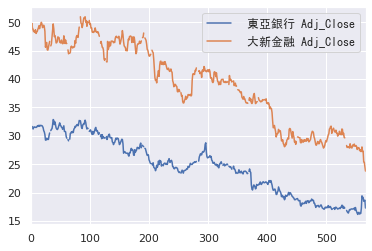

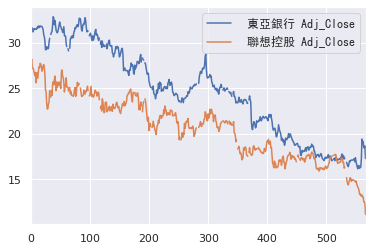

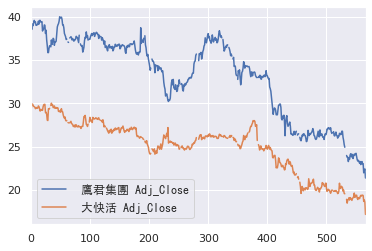

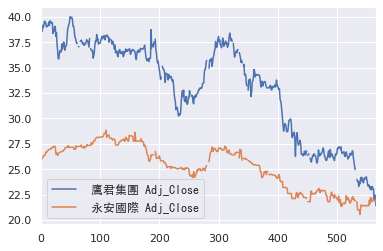

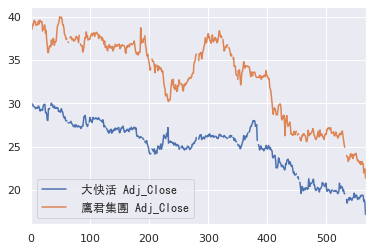

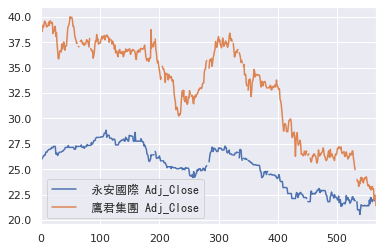

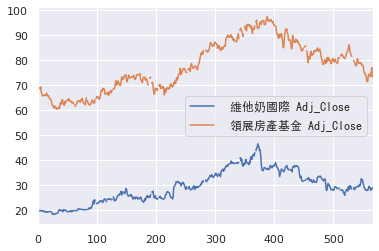

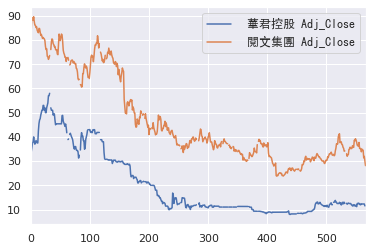

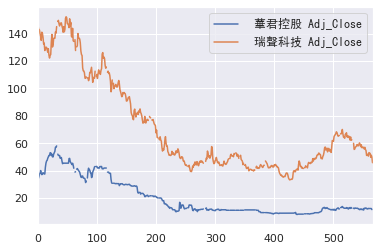

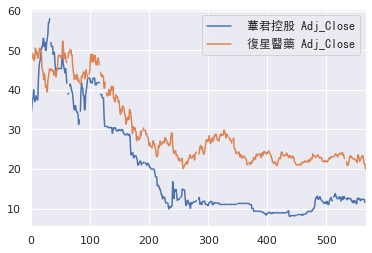

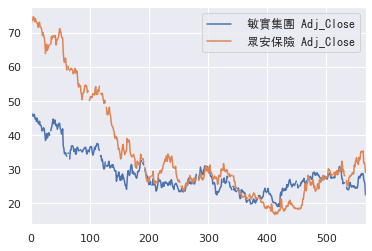

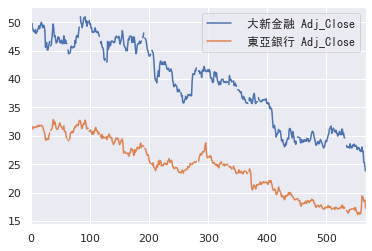

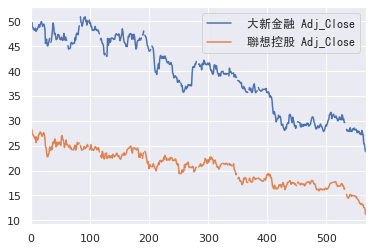

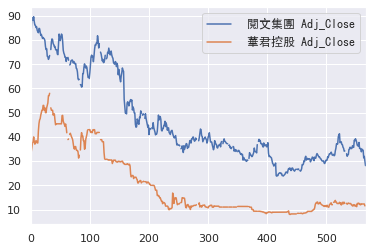

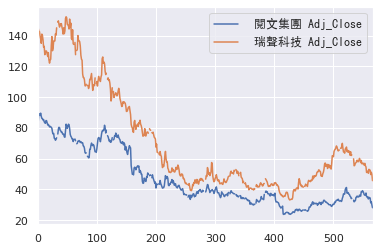

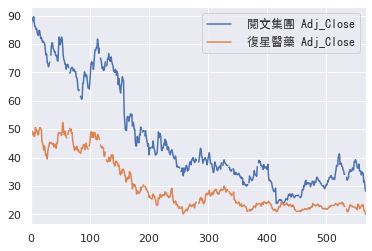

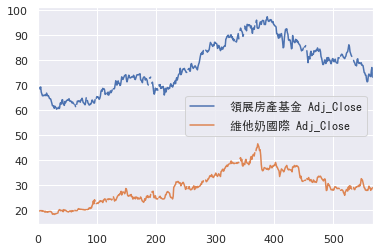

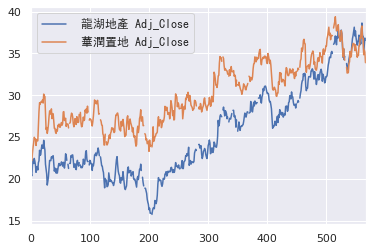

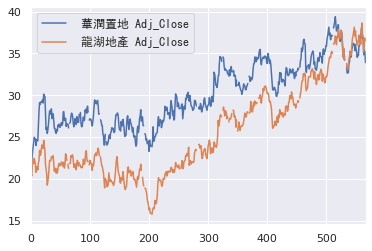

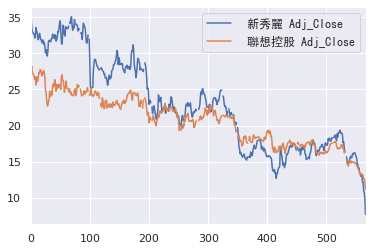

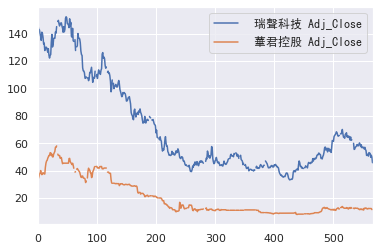

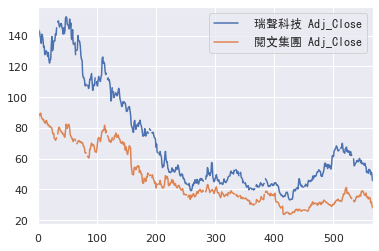

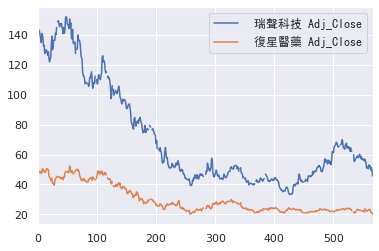

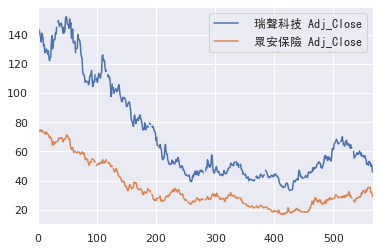

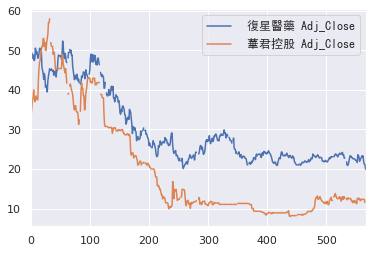

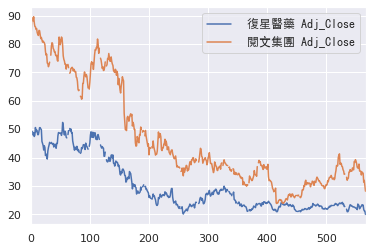

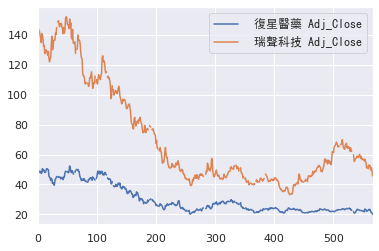

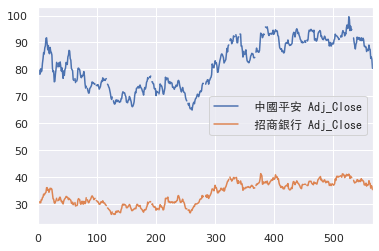

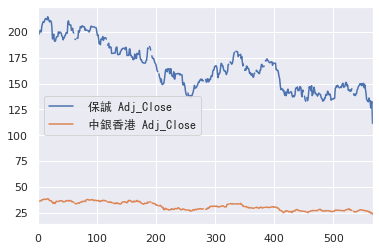

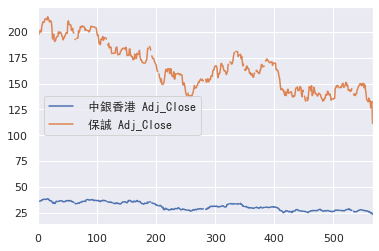

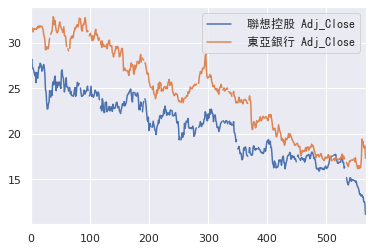

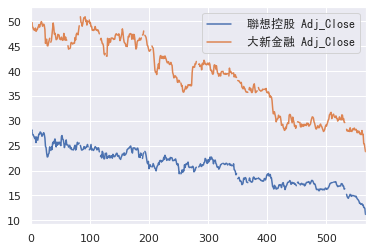

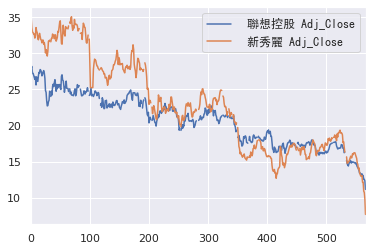

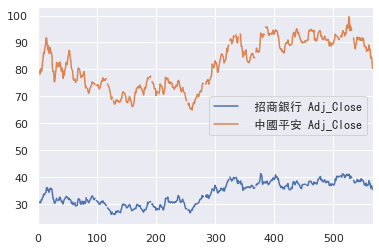

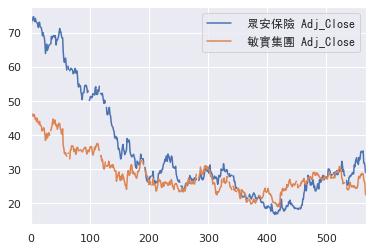

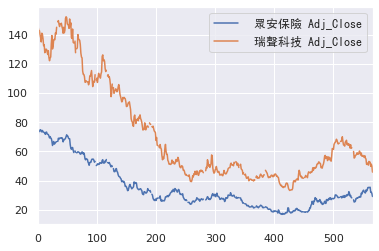

In [0]:
for i in range(len(result[1])):
  New_DataInformation[[Index_Name[result[0][i]],Columns_Name[result[1][i]]]].plot()
  plt.legend(prop = CNFont)
  print(Index_Name[result[0][i]])
  print(Columns_Name[result[1][i]])

In [0]:
TargetStock = [' 招商銀行 Adj_Close',' 中國平安 Adj_Close',' 東亞銀行 Adj_Close',' 大新金融 Adj_Close',' 眾安保險 Adj_Close',' 瑞聲科技 Adj_Close']
TargetStockDataInformation = New_DataInformation[TargetStock]
TargetStockDataInformation

,招商銀行 Adj_Close,中國平安 Adj_Close,東亞銀行 Adj_Close,大新金融 Adj_Close,眾安保險 Adj_Close,瑞聲科技 Adj_Close
0,30.334574,80.893616,31.522160,47.366707,70.300003,142.027252
1,30.897194,79.751587,31.197186,48.112644,72.400002,144.587158
2,30.990963,79.799164,31.661430,49.790989,74.199997,142.690948
3,30.568998,78.276459,31.475737,48.951813,73.800003,142.596115
4,30.803425,78.276459,31.197186,48.765331,74.750000,139.656982
...,...,...,...,...,...,...
562,37.750000,87.400002,19.160000,27.299999,35.400002,52.549999
563,36.000000,84.099998,18.500000,25.400000,31.950001,49.700001
564,36.900002,84.599998,18.480000,25.350000,31.950001,51.200001
565,36.700001,83.800003,18.680000,24.549999,31.150000,49.900002


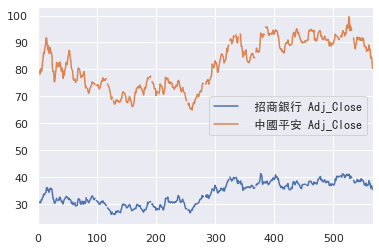

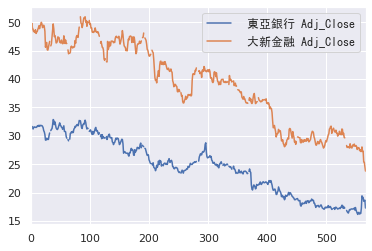

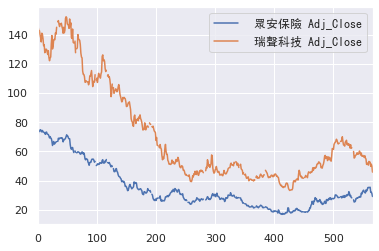

In [0]:
TargetStockDataInformation[[TargetStock[0],TargetStock[1]]].plot()
plt.legend(prop = CNFont)

TargetStockDataInformation[[TargetStock[2],TargetStock[3]]].plot()
plt.legend(prop = CNFont)

TargetStockDataInformation[[TargetStock[4],TargetStock[5]]].plot()
plt.legend(prop = CNFont)

In [0]:
DIFF_Data = pd.DataFrame()
DIFF_Data['DIFF 1'] = TargetStockDataInformation[TargetStock[0]] - TargetStockDataInformation[TargetStock[1]]
DIFF_Data['DIFF 2'] = TargetStockDataInformation[TargetStock[2]] - TargetStockDataInformation[TargetStock[3]]
DIFF_Data['DIFF 3'] = TargetStockDataInformation[TargetStock[4]] - TargetStockDataInformation[TargetStock[5]]
DIFF_Data.describe()

,DIFF 1,DIFF 2,DIFF 3
count,542.000000,542.000000,542.000000
mean,-48.039569,-14.608903,-36.401621
std,5.170103,2.855299,19.482640
min,-58.350002,-20.810013,-85.895168
25%,-52.625001,-16.827910,-53.827872
50%,-48.445778,-14.708892,-27.224999
75%,-43.380056,-12.337574,-20.072045
max,-37.171473,-5.869999,-13.445177


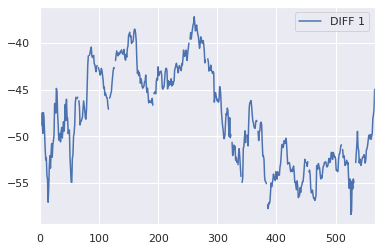

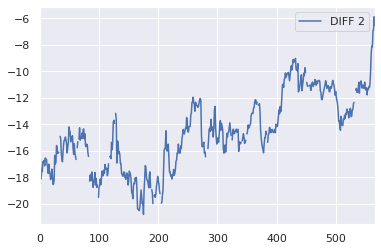

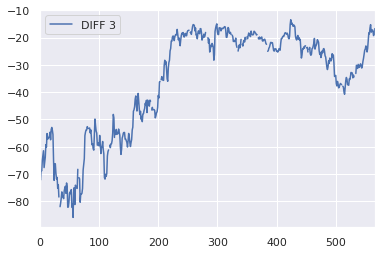

In [0]:
DIFF_Data[['DIFF 1']].plot()
DIFF_Data[['DIFF 2']].plot()
DIFF_Data[['DIFF 3']].plot()

In [0]:
TargetStockDataInformation[[TargetStock[0],TargetStock[1]]].corr()

,招商銀行 Adj_Close,中國平安 Adj_Close
招商銀行 Adj_Close,1.000000,0.944951
中國平安 Adj_Close,0.944951,1.000000


In [0]:
TargetStockDataInformation[[TargetStock[2],TargetStock[3]]].corr()

,東亞銀行 Adj_Close,大新金融 Adj_Close
東亞銀行 Adj_Close,1.000000,0.966855
大新金融 Adj_Close,0.966855,1.000000


In [0]:
TargetStockDataInformation[[TargetStock[4],TargetStock[5]]].corr()

,眾安保險 Adj_Close,瑞聲科技 Adj_Close
眾安保險 Adj_Close,1.000000,0.961075
瑞聲科技 Adj_Close,0.961075,1.000000


In [0]:
Corr_Data_Lag1 = pd.DataFrame()
Corr_Data_Lag2 = pd.DataFrame()
Corr_Data_Lag3 = pd.DataFrame()

Corr_Data_Lag1[str(TargetStock[0])] = TargetStockDataInformation[TargetStock[0]].shift(1)
Corr_Data_Lag1[str(TargetStock[1])] = TargetStockDataInformation[TargetStock[1]]
Corr_Data_Lag1.corr()


,招商銀行 Adj_Close,中國平安 Adj_Close
招商銀行 Adj_Close,1.000000,0.939663
中國平安 Adj_Close,0.939663,1.000000


In [0]:
Corr_Data_Lag1[str(TargetStock[0])] = TargetStockDataInformation[TargetStock[0]].shift(1)
Corr_Data_Lag1[str(TargetStock[1])] = TargetStockDataInformation[TargetStock[1]]
Corr_Data_Lag1.drop(index =0,inplace=True)
Corr_Data_Lag1.reset_index(inplace = True)
del Corr_Data_Lag1['index']
Corr_Data_Lag1

,招商銀行 Adj_Close,中國平安 Adj_Close
0,30.334574,79.751587
1,30.897194,79.799164
2,30.990963,78.276459
3,30.568998,78.276459
4,30.803425,80.227440
...,...,...
561,37.750000,87.400002
562,37.750000,84.099998
563,36.000000,84.599998
564,36.900002,83.800003


In [0]:
Corr_Data_Lag2[str(TargetStock[2])] = TargetStockDataInformation[TargetStock[2]].shift(1)
Corr_Data_Lag2[str(TargetStock[3])] = TargetStockDataInformation[TargetStock[3]]
Corr_Data_Lag2.drop(index =0,inplace=True)
Corr_Data_Lag2.reset_index(inplace = True)
del Corr_Data_Lag2['index']

In [0]:
Corr_Data_Lag3[str(TargetStock[4])] = TargetStockDataInformation[TargetStock[4]].shift(1)
Corr_Data_Lag3[str(TargetStock[5])] = TargetStockDataInformation[TargetStock[5]]
Corr_Data_Lag3.drop(index =0,inplace=True)
Corr_Data_Lag3.reset_index(inplace = True)
del Corr_Data_Lag3['index']


In [0]:
Corr_Data_Lag1_T = Corr_Data_Lag1.dropna(axis = 0 ,how = 'any')
Corr_Data_Lag1_T.reset_index(inplace = True)
del Corr_Data_Lag1_T['index']

Corr_Data_Lag2_T = Corr_Data_Lag2.dropna(axis = 0 ,how = 'any')
Corr_Data_Lag2_T.reset_index(inplace = True)
del Corr_Data_Lag2_T['index']

Corr_Data_Lag3_T = Corr_Data_Lag3.dropna(axis = 0 ,how = 'any')
Corr_Data_Lag3_T.reset_index(inplace = True)
del Corr_Data_Lag3_T['index']

In [0]:
Corr_Data_Lag1_Train = Corr_Data_Lag1_T[:int(len(Corr_Data_Lag1)*0.6)]
Corr_Data_Lag1_Test = Corr_Data_Lag1_T[int(len(Corr_Data_Lag1)*0.6):]

Corr_Data_Lag2_Train = Corr_Data_Lag2_T[:int(len(Corr_Data_Lag2)*0.6)]
Corr_Data_Lag2_Test = Corr_Data_Lag2_T[int(len(Corr_Data_Lag2)*0.6):]

Corr_Data_Lag3_Train = Corr_Data_Lag3_T[:int(len(Corr_Data_Lag3)*0.6)]
Corr_Data_Lag3_Test = Corr_Data_Lag3_T[int(len(Corr_Data_Lag3)*0.6):]

In [0]:
# TargetStock = [' 招商銀行 Adj_Close',' 中國平安 Adj_Close',' 東亞銀行 Adj_Close',' 大新金融 Adj_Close',' 眾安保險 Adj_Close',' 瑞聲科技 Adj_Close']
Small_Period_Train = [5,10,10,15]
Small_Period_Test = [2,2,5,5]
Corr_Data_Train_List = [Corr_Data_Lag1_Train,Corr_Data_Lag2_Train,Corr_Data_Lag3_Train]
Corr_Data_Train_Label = ['招商銀行-中國平安','東亞銀行-大新金融','眾安保險-瑞聲科技']
for T,Lag in enumerate(Corr_Data_Train_List):
  Train_Length = len(Lag)
  print('Testing Pair of Stocks:%s'%Corr_Data_Train_Label[T])
  for p in range(len(Small_Period_Train)):
    Sum_MSE = []
    Sum_R2 = []
    Period = int(Small_Period_Test[p] + Small_Period_Train[p])
    for i in range(0,Train_Length,Period):
      if Small_Period_Train[p]+i >= Train_Length:
        print('Small Training Period :%s'%Small_Period_Train[p])
        print('Small Testing Period :%s'%Small_Period_Test[p])
        print('Total Mean Squared Error:%.2f' % sum(Sum_MSE))
        print('Total Coefficient of determination: %.2f' % sum(Sum_R2))
        print('\n')
        break
      else:
        Data_X_Train = np.array([Lag[TargetStock[T*2]][i:Small_Period_Train[p]+i]]).T
        Data_Y_Train = np.array([Lag[TargetStock[T*2+1]][i:Small_Period_Train[p]+i]]).T
        if Small_Period_Train[p]+Small_Period_Test[p]+i > Train_Length:
          Data_X_Test = np.array([Lag[TargetStock[T*2]][Small_Period_Train[p]+i:]]).T
          Data_Y_Test = np.array([Lag[TargetStock[T*2+1]][Small_Period_Train[p]+i:]]).T
        else:
          Data_X_Test = np.array([Lag[TargetStock[T*2]][Small_Period_Train[p]+i:Small_Period_Train[p]+Small_Period_Test[p]+i]]).T
          Data_Y_Test = np.array([Lag[TargetStock[T*2+1]][Small_Period_Train[p]+i:Small_Period_Train[p]+Small_Period_Test[p]+i]]).T
        regr = LinearRegression()
        regr.fit(Data_X_Train, Data_Y_Train)
        Data_Y_Predict = regr.predict(Data_X_Test)
        Sum_MSE.append(mean_squared_error(Data_Y_Test, Data_Y_Predict))
        Sum_R2.append(r2_score(Data_Y_Test, Data_Y_Predict))

        if Small_Period_Train[p]+Small_Period_Test[p]+i >= Train_Length:
          print('Small Period Train Date %s'%Small_Period_Train[p])
          print('Small Period Test Date %s'%Small_Period_Test[p])
          print('Total Mean Squared Error:%.2f' % sum(Sum_MSE))
          print('Total Coefficient of determination: %.2f' % sum(Sum_R2))
          print('\n')
          break


Testing Pair of Stocks:招商銀行-中國平安
Small Training Period :5
Small Testing Period :2
Total Mean Squared Error:243.58
Total Coefficient of determination: -25378.41


Small Training Period :10
Small Testing Period :2
Total Mean Squared Error:82.97
Total Coefficient of determination: -2388.75


Small Training Period :10
Small Testing Period :5
Total Mean Squared Error:203.09
Total Coefficient of determination: -211.91


Small Period Train Date 15
Small Period Test Date 5
Total Mean Squared Error:122.91
Total Coefficient of determination: -176.47


Testing Pair of Stocks:東亞銀行-大新金融
Small Training Period :5
Small Testing Period :2
Total Mean Squared Error:84.19
Total Coefficient of determination: -34221.35


Small Training Period :10
Small Testing Period :2
Total Mean Squared Error:47.39
Total Coefficient of determination: -3450.39


Small Training Period :10
Small Testing Period :5
Total Mean Squared Error:42.72
Total Coefficient of determination: -309.84


Small Period Train Date 15
Small Per

In [0]:
# TargetStock = [' 招商銀行 Adj_Close',' 中國平安 Adj_Close',' 東亞銀行 Adj_Close',' 大新金融 Adj_Close',' 眾安保險 Adj_Close',' 瑞聲科技 Adj_Close']
TargetStockDataCode = '''select * from HKStock where Name in (' 招商銀行',' 中國平安',' 東亞銀行',' 大新金融',' 眾安保險',' 瑞聲科技') '''
TargetStockDataAgg = pd.read_sql(TargetStockDataCode,con =con)


In [0]:
TargetStockSymbol = [' 招商銀行',' 中國平安',' 東亞銀行',' 大新金融',' 眾安保險',' 瑞聲科技']
Temporary = TargetStockDataAgg[TargetStockDataAgg['Name'].isin([TargetStockSymbol[0]])]
Temporary.index = Temporary['TradeDate']
SymbolH = ''.join([str(Name), ' High'])
SymbolL = ''.join([str(Name), ' Low'])
SymbolO = ''.join([str(Name), ' Open'])
SymbolC = ''.join([str(Name), ' Close'])
Temporary.rename(columns = {'High':SymbolH,'Low':SymbolL,'Open':SymbolO,'Close':SymbolC},inplace = True)

In [0]:
TargetStockSymbol = [' 招商銀行',' 中國平安',' 東亞銀行',' 大新金融',' 眾安保險',' 瑞聲科技']
TargetStockData = pd.DataFrame()
for i,Name in enumerate(TargetStockSymbol):
    Temporary = TargetStockDataAgg[TargetStockDataAgg['Name'].isin([Name])]
    Temporary.index = Temporary['TradeDate']
    SymbolH = ''.join([str(Name), ' High'])
    SymbolL = ''.join([str(Name), ' Low'])
    SymbolO = ''.join([str(Name), ' Open'])
    SymbolC = ''.join([str(Name), ' Close'])
    Temporary.rename(columns = {'High':SymbolH,'Low':SymbolL,'Open':SymbolO,'Close':SymbolC},inplace = True)
    TargetStockData  = pd.concat([TargetStockData,Temporary[[SymbolO,SymbolH,SymbolL,SymbolC]]],axis=1)

In [0]:
TargetStockData = TargetStockData.dropna(axis = 0 ,how = 'any')

In [0]:
TargetStockData_Train = TargetStockData[:int(len(TargetStockData)*0.6)]
TargetStockData_Test = TargetStockData[int(len(TargetStockData)*0.6):]

Initialization account....
Your Account has $ 1000000
The pair stock is :  招商銀行
The target stock is :  中國平安
Back Test Begins ! Starts on  20190502 

----------------------------
On  20190521  You create a  Buy Order  with  8000  shares at $  84.9 .
The position ratio is  67.92 %. 
At the end of business date , You exit your position at $ 84.9 .
Your Net Income at this order is $ 0.0 
Now , Your Total Cash is $ 1000000.0 

On  20190523  You create a  Buy Order  with  8000  shares at $  83.75 .
The position ratio is  67.0 %. 
At the end of business date , You exit your position at $ 83.25 .
Your Net Income at this order is $ -4000.0 
Now , Your Total Cash is $ 996000.0 

On  20190530  You create a  Sell Order  with  8000  shares at $  87.1 .
The position ratio is  69.96 %. 
At the end of business date , You exit your position at $ 86.8 .
Your Net Income at this order is $ 2399.96 
Now , Your Total Cash is $ 998399.96 

On  20190531  You create a  Sell Order  with  8000  shares at $  87.4

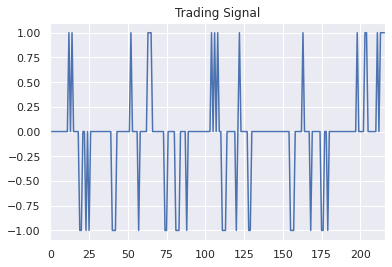

In [0]:

Final_Period_Train = 10
# TargetStockSymbol = [' 招商銀行',' 中國平安',' 東亞銀行',' 大新金融',' 眾安保險',' 瑞聲科技']
Cash = 1000000
Board_Lot = 20
Shares = 400 * Board_Lot

X_Close_Name = ''.join([TargetStockSymbol[0], ' Close'])
Y_Close_Name = ''.join([TargetStockSymbol[1], ' Close'])
Y_High_Name = ''.join([TargetStockSymbol[1], ' High'])
Y_Low_Name = ''.join([TargetStockSymbol[1], ' Low'])
Y_Open_Name = ''.join([TargetStockSymbol[1], ' Open'])

XYDataInformation_1 = TargetStockData_Test.copy()
XYDataInformation_1.reset_index(inplace = True)
XYDataInformation_1['Benchmark Return'] = XYDataInformation_1[X_Close_Name] / XYDataInformation_1[X_Close_Name][0] - 1
XYDataInformation_1['Strategy Return'] = np.nan
XYDataInformation_1['Predict Value'] = np.nan
XYDataInformation_1['Trade Signal'] = np.nan
XYDataInformation_1['Y Stock Vol'] = XYDataInformation_1[Y_Close_Name].rolling(10).std()

for i in range(Final_Period_Train+2,len(XYDataInformation_1)):
  Data_X_Train = np.array([XYDataInformation_1[X_Close_Name][i-Final_Period_Train-2:i-2]]).T
  Data_Y_Train = np.array([XYDataInformation_1[Y_Close_Name][i-Final_Period_Train-1:i-1]]).T
  regr = LinearRegression()
  regr.fit(Data_X_Train, Data_Y_Train)
  # print(XYDataInformation_1[X_Close_Name][i-1])
  Predict_Value = regr.predict(np.array([[XYDataInformation_1[X_Close_Name][i-1]]]))
  XYDataInformation_1['Predict Value'][i] = Predict_Value

BeginCash = Cash
print('Initialization account....')
time.sleep(2)
print('Your Account has $', BeginCash)
print('The pair stock is :',str(TargetStockSymbol[0]))
print('The target stock is :', str(TargetStockSymbol[1]))
time.sleep(2)
print('Back Test Begins ! Starts on ', XYDataInformation_1['TradeDate'][0], '\n\n----------------------------')
time.sleep(2)

for i in range(Final_Period_Train + 2, len(XYDataInformation_1)):
  
  if XYDataInformation_1[Y_Open_Name][i] <= XYDataInformation_1['Predict Value'][i] - 2 * XYDataInformation_1['Y Stock Vol'][i]:
      SharesOrderStatus = 'Buy Order'
      LongPosition = Shares * XYDataInformation_1[Y_Open_Name][i]
      Position_Ratio = round(LongPosition/BeginCash*100,2)
      BeginCash = BeginCash -  LongPosition
      LongSell = Shares * XYDataInformation_1[Y_Close_Name][i]
      EndCash = BeginCash + LongSell
      Net_Income = LongSell - LongPosition
      BeginCash = EndCash
      XYDataInformation_1['Trade Signal'][i] = 1
      XYDataInformation_1['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_1['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_1[Y_Open_Name][i],
                'Sell Price':XYDataInformation_1[Y_Close_Name][i],
                'Position Ratio':Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')


  if XYDataInformation_1[Y_Low_Name][i] <= XYDataInformation_1['Predict Value'][i] - 2 * XYDataInformation_1['Y Stock Vol'][i] and XYDataInformation_1['Trade Signal'][i] == np.nan:
      SharesOrderStatus = 'Buy Order'
      LongPosition = Shares * XYDataInformation_1['Predict Value'][i] - 2 * XYDataInformation_1['Y Stock Vol'][i] 
      Position_Ratio = round(LongPosition / BeginCash*100, 2)
      BeginCash = BeginCash -  LongPosition
      LongSell = Shares * XYDataInformation_1[Y_Close_Name][i]
      EndCash = BeginCash + LongSell
      Net_Income = LongSell - LongPosition
      BeginCash = EndCash
      XYDataInformation_1['Trade Signal'][i] = 1
      XYDataInformation_1['Strategy Return'][i] = BeginCash / Cash - 1

      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_1['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_1[Y_Open_Name][i],
                'Sell Price':XYDataInformation_1[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')


  if XYDataInformation_1[Y_Open_Name][i] >= XYDataInformation_1['Predict Value'][i] + 2 * XYDataInformation_1['Y Stock Vol'][i]:
      SharesOrderStatus = 'Sell Order'
      ShortPosition = Shares * XYDataInformation_1[Y_Open_Name][i]
      Position_Ratio = round(ShortPosition / BeginCash*100, 2)
      BeginCash = BeginCash +  ShortPosition
      ShortSell = Shares * XYDataInformation_1[Y_Close_Name][i]
      EndCash = BeginCash - ShortSell
      Net_Income = -ShortSell + ShortPosition
      BeginCash = EndCash
      XYDataInformation_1['Trade Signal'][i] = -1
      XYDataInformation_1['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_1['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_1[Y_Open_Name][i],
                'Sell Price':XYDataInformation_1[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')

  if XYDataInformation_1[Y_High_Name][i] >= XYDataInformation_1['Predict Value'][i] + 2 * XYDataInformation_1['Y Stock Vol'][i] and XYDataInformation_1['Trade Signal'][i] == np.nan:
      SharesOrderStatus = 'Sell Order'
      ShortPosition = Shares * YDataInformation_1['Predict Value'][i] + 2 * XYDataInformation_1['Y Stock Vol'][i] 
      Position_Ratio = round(ShortPosition / BeginCash*100, 2)
      BeginCash = BeginCash + ShortPosition
      ShortSell = Shares * XYDataInformation_1[Y_Close_Name][i]
      EndCash = BeginCash - ShortSell
      Net_Income = -ShortSell + ShortPosition
      BeginCash = EndCash
      XYDataInformation_1['Trade Signal'][i] = -1
      XYDataInformation_1['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_1['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_1[Y_Open_Name][i],
                'Sell Price': XYDataInformation_1[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2), '.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',
            round(Order['Sell Price'], 2), '.\nYour Net Income at this order is $', round(Order['Net Income'], 2),
            '\nNow , Your Total Cash is $', round(Order['Total Cash'], 2),'\n')
  XYDataInformation_1['Strategy Return'][i] = BeginCash / Cash - 1
  
Net_Income_1 = round(Order['Total Cash']-Cash,2)
Net_Return_1 = round(Net_Income_1/Cash,2)
print('\n\n\n---------------------------------------')
print('Back Test Ends! \nStart Date:', XYDataInformation_1['TradeDate'][0], '\nEnd Date:',
      XYDataInformation_1['TradeDate'][len(XYDataInformation_1) - 1], '\nYou account has $', round(Order['Total Cash'], 2),
      '.\nYour Total Net Income is $',Net_Income_1,
      '.\nYour Net Return is %.2f' % (Net_Return_1 * 100), '%.')

plt.legend
XYDataInformation_1['Trade Signal'].fillna(0,inplace=True)
XYDataInformation_1['Trade Signal'].plot()
plt.title('Trading Signal')
plt.show()


Initialization account....
Your Account has $ 1000000
The pair stock is :  東亞銀行
The target stock is :  大新金融
Back Test Begins ! Starts on  20190502 

----------------------------
On  20190524  You create a  Buy Order  with  8000  shares at $  38.3 .
The position ratio is  30.64 %. 
At the end of business date , You exit your position at $ 38.2 .
Your Net Income at this order is $ -799.99 
Now , Your Total Cash is $ 999200.01 

On  20190527  You create a  Buy Order  with  8000  shares at $  38.2 .
The position ratio is  30.58 %. 
At the end of business date , You exit your position at $ 38.0 .
Your Net Income at this order is $ -1600.01 
Now , Your Total Cash is $ 997600.01 

On  20190528  You create a  Buy Order  with  8000  shares at $  38.1 .
The position ratio is  30.55 %. 
At the end of business date , You exit your position at $ 38.5 .
Your Net Income at this order is $ 3200.01 
Now , Your Total Cash is $ 1000800.02 

On  20190606  You create a  Buy Order  with  8000  shares at $  

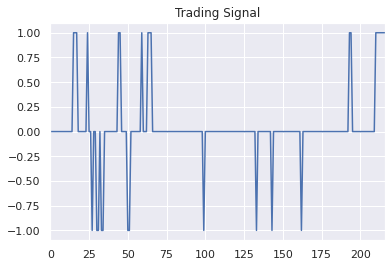

In [0]:
Final_Period_Train = 10
# TargetStockSymbol = [' 招商銀行',' 中國平安',' 東亞銀行',' 大新金融',' 眾安保險',' 瑞聲科技']
Cash = 1000000
Board_Lot = 20
Shares = 400 * Board_Lot

X_Close_Name = ''.join([TargetStockSymbol[2], ' Close'])
Y_Close_Name = ''.join([TargetStockSymbol[3], ' Close'])
Y_High_Name = ''.join([TargetStockSymbol[3], ' High'])
Y_Low_Name = ''.join([TargetStockSymbol[3], ' Low'])
Y_Open_Name = ''.join([TargetStockSymbol[3], ' Open'])

XYDataInformation_2 = TargetStockData_Test.copy()
XYDataInformation_2.reset_index(inplace = True)
XYDataInformation_2['Benchmark Return'] = XYDataInformation_2[X_Close_Name] / XYDataInformation_2[X_Close_Name][0] - 1
XYDataInformation_2['Strategy Return'] = np.nan
XYDataInformation_2['Predict Value'] = np.nan
XYDataInformation_2['Trade Signal'] = np.nan
XYDataInformation_2['Y Stock Vol'] = XYDataInformation_2[Y_Close_Name].rolling(10).std()

for i in range(Final_Period_Train+2,len(XYDataInformation_2)):
  Data_X_Train = np.array([XYDataInformation_2[X_Close_Name][i-Final_Period_Train-2:i-2]]).T
  Data_Y_Train = np.array([XYDataInformation_2[Y_Close_Name][i-Final_Period_Train-1:i-1]]).T
  regr = LinearRegression()
  regr.fit(Data_X_Train, Data_Y_Train)
  # print(XYDataInformation_2[X_Close_Name][i-1])
  Predict_Value = regr.predict(np.array([[XYDataInformation_2[X_Close_Name][i-1]]]))
  XYDataInformation_2['Predict Value'][i] = Predict_Value

BeginCash = Cash
print('Initialization account....')
time.sleep(2)
print('Your Account has $', BeginCash)
print('The pair stock is :',str(TargetStockSymbol[2]))
print('The target stock is :', str(TargetStockSymbol[3]))
time.sleep(2)
print('Back Test Begins ! Starts on ', XYDataInformation_2['TradeDate'][0], '\n\n----------------------------')
time.sleep(2)

for i in range(Final_Period_Train + 2, len(XYDataInformation_2)):
  if XYDataInformation_2[Y_Open_Name][i] <= XYDataInformation_2['Predict Value'][i] - 2 * XYDataInformation_2['Y Stock Vol'][i]:
      SharesOrderStatus = 'Buy Order'
      LongPosition = Shares * XYDataInformation_2[Y_Open_Name][i]
      Position_Ratio = round(LongPosition/BeginCash*100,2)
      BeginCash = BeginCash -  LongPosition
      LongSell = Shares * XYDataInformation_2[Y_Close_Name][i]
      EndCash = BeginCash + LongSell
      Net_Income = LongSell - LongPosition
      BeginCash = EndCash
      XYDataInformation_2['Trade Signal'][i] = 1
      XYDataInformation_2['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_2['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_2[Y_Open_Name][i],
                'Sell Price':XYDataInformation_2[Y_Close_Name][i],
                'Position Ratio':Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')


  if XYDataInformation_2[Y_Low_Name][i] <= XYDataInformation_2['Predict Value'][i] - 2 * XYDataInformation_2['Y Stock Vol'][i] and XYDataInformation_2['Trade Signal'][i] == np.nan:
      SharesOrderStatus = 'Buy Order'
      LongPosition = Shares * XYDataInformation_2['Predict Value'][i] - 2 * XYDataInformation_2['Y Stock Vol'][i]
      Position_Ratio = round(LongPosition / BeginCash*100, 2)
      BeginCash = BeginCash -  LongPosition
      LongSell = Shares * XYDataInformation_2[Y_Close_Name][i]
      EndCash = BeginCash + LongSell
      Net_Income = LongSell - LongPosition
      BeginCash = EndCash
      XYDataInformation_2['Trade Signal'][i] = 1
      XYDataInformation_2['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_2['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_2[Y_Open_Name][i],
                'Sell Price':XYDataInformation_2[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')


  if XYDataInformation_2[Y_Open_Name][i] >= XYDataInformation_2['Predict Value'][i] + 2 * XYDataInformation_2['Y Stock Vol'][i]:
      SharesOrderStatus = 'Sell Order'
      ShortPosition = Shares * XYDataInformation_2[Y_Open_Name][i]
      Position_Ratio = round(ShortPosition / BeginCash*100, 2)
      BeginCash = BeginCash +  ShortPosition
      ShortSell = Shares * XYDataInformation_2[Y_Close_Name][i]
      EndCash = BeginCash - ShortSell
      Net_Income = -ShortSell + ShortPosition
      BeginCash = EndCash
      XYDataInformation_2['Trade Signal'][i] = -1
      XYDataInformation_2['Strategy Return'][i] = BeginCash / Cash - 1

      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_2['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_2[Y_Open_Name][i],
                'Sell Price':XYDataInformation_2[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')

  if XYDataInformation_2[Y_High_Name][i] >= XYDataInformation_2['Predict Value'][i] + 2 * XYDataInformation_2['Y Stock Vol'][i] and XYDataInformation_2['Trade Signal'][i] == np.nan:
      SharesOrderStatus = 'Sell Order'
      ShortPosition = Shares * XYDataInformation_2['Predict Value'][i] + 2 * XYDataInformation_2['Y Stock Vol'][i]
      Position_Ratio = round(ShortPosition / BeginCash*100, 2)
      BeginCash = BeginCash + ShortPosition
      ShortSell = Shares * XYDataInformation_2[Y_Close_Name][i]
      EndCash = BeginCash - ShortSell
      Net_Income = -ShortSell + ShortPosition
      BeginCash = EndCash
      XYDataInformation_2['Trade Signal'][i] = -1
      XYDataInformation_2['Strategy Return'][i] = BeginCash / Cash - 1

      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_2['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_2[Y_Open_Name][i],
                'Sell Price': XYDataInformation_2[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2), '.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',
            round(Order['Sell Price'], 2), '.\nYour Net Income at this order is $', round(Order['Net Income'], 2),
            '\nNow , Your Total Cash is $', round(Order['Total Cash'], 2),'\n')
  XYDataInformation_2['Strategy Return'][i] = BeginCash / Cash - 1
  
Net_Income_2 = round(Order['Total Cash']-Cash,2)
Net_Return_2 = round(Net_Income_2/Cash,2)
print('\n\n\n---------------------------------------')
print('Back Test Ends! \nStart Date:', XYDataInformation_2['TradeDate'][0], '\nEnd Date:',
      XYDataInformation_2['TradeDate'][len(XYDataInformation_2) - 1], '\nYou account has $', round(Order['Total Cash'], 2),
      '.\nYour Total Net Income is $',Net_Income_2,
      '.\nYour Net Return is %.2f' % (Net_Return_2 * 100), '%.')

plt.legend
XYDataInformation_2['Trade Signal'].fillna(0,inplace=True)
XYDataInformation_2['Trade Signal'].plot()
plt.title('Trading Signal')
plt.show()



Initialization account....
Your Account has $ 1000000
The pair stock is :  眾安保險
The target stock is :  瑞聲科技
Back Test Begins ! Starts on  20190502 

----------------------------
On  20190619  You create a  Sell Order  with  8000  shares at $  45.0 .
The position ratio is  36.0 %. 
At the end of business date , You exit your position at $ 44.25 .
Your Net Income at this order is $ 6000.0 
Now , Your Total Cash is $ 1006000.0 

On  20190628  You create a  Sell Order  with  8000  shares at $  44.5 .
The position ratio is  35.39 %. 
At the end of business date , You exit your position at $ 44.35 .
Your Net Income at this order is $ 1200.01 
Now , Your Total Cash is $ 1007200.01 

On  20190702  You create a  Sell Order  with  8000  shares at $  46.85 .
The position ratio is  37.21 %. 
At the end of business date , You exit your position at $ 47.5 .
Your Net Income at this order is $ -5200.01 
Now , Your Total Cash is $ 1002000.0 

On  20190703  You create a  Sell Order  with  8000  shares a

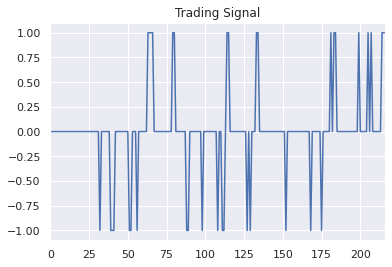

In [0]:
Final_Period_Train = 10
# TargetStockSymbol = [' 招商銀行',' 中國平安',' 東亞銀行',' 大新金融',' 眾安保險',' 瑞聲科技']
Cash = 1000000
Board_Lot = 20
Shares = 400 * Board_Lot

X_Close_Name = ''.join([TargetStockSymbol[4], ' Close'])
Y_Close_Name = ''.join([TargetStockSymbol[5], ' Close'])
Y_High_Name = ''.join([TargetStockSymbol[5], ' High'])
Y_Low_Name = ''.join([TargetStockSymbol[5], ' Low'])
Y_Open_Name = ''.join([TargetStockSymbol[5], ' Open'])

XYDataInformation_3 = TargetStockData_Test.copy()
XYDataInformation_3.reset_index(inplace = True)
XYDataInformation_3['Benchmark Return'] = XYDataInformation_3[X_Close_Name] / XYDataInformation_3[X_Close_Name][0] - 1
XYDataInformation_3['Strategy Return'] = np.nan
XYDataInformation_3['Predict Value'] = np.nan
XYDataInformation_3['Trade Signal'] = np.nan
XYDataInformation_3['Y Stock Vol'] = XYDataInformation_3[Y_Close_Name].rolling(10).std()

for i in range(Final_Period_Train+2,len(XYDataInformation_3)):
  Data_X_Train = np.array([XYDataInformation_3[X_Close_Name][i-Final_Period_Train-2:i-2]]).T
  Data_Y_Train = np.array([XYDataInformation_3[Y_Close_Name][i-Final_Period_Train-1:i-1]]).T
  regr = LinearRegression()
  regr.fit(Data_X_Train, Data_Y_Train)
  # print(XYDataInformation_3[X_Close_Name][i-1])
  Predict_Value = regr.predict(np.array([[XYDataInformation_3[X_Close_Name][i-1]]]))
  XYDataInformation_3['Predict Value'][i] = Predict_Value

BeginCash = Cash
print('Initialization account....')
time.sleep(2)
print('Your Account has $', BeginCash)
print('The pair stock is :',str(TargetStockSymbol[4]))
print('The target stock is :', str(TargetStockSymbol[5]))
time.sleep(2)
print('Back Test Begins ! Starts on ', XYDataInformation_3['TradeDate'][0], '\n\n----------------------------')
time.sleep(2)

for i in range(Final_Period_Train + 2, len(XYDataInformation_3)):
  if XYDataInformation_3[Y_Open_Name][i] <= XYDataInformation_3['Predict Value'][i] - 2 * XYDataInformation_3['Y Stock Vol'][i]:
      SharesOrderStatus = 'Buy Order'
      LongPosition = Shares * XYDataInformation_3[Y_Open_Name][i]
      Position_Ratio = round(LongPosition/BeginCash*100,2)
      BeginCash = BeginCash -  LongPosition
      LongSell = Shares * XYDataInformation_3[Y_Close_Name][i]
      EndCash = BeginCash + LongSell
      Net_Income = LongSell - LongPosition
      BeginCash = EndCash
      XYDataInformation_3['Trade Signal'][i] = 1
      XYDataInformation_3['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_3['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_3[Y_Open_Name][i],
                'Sell Price':XYDataInformation_3[Y_Close_Name][i],
                'Position Ratio':Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')


  if XYDataInformation_3[Y_Low_Name][i] <= XYDataInformation_3['Predict Value'][i] - 2 * XYDataInformation_3['Y Stock Vol'][i] and XYDataInformation_3['Trade Signal'][i] == np.nan:
      SharesOrderStatus = 'Buy Order'
      LongPosition = Shares * XYDataInformation_3['Predict Value'][i] - 2 * XYDataInformation_3['Y Stock Vol'][i]
      Position_Ratio = round(LongPosition / BeginCash*100, 2)
      BeginCash = BeginCash -  LongPosition
      LongSell = Shares * XYDataInformation_3[Y_Close_Name][i]
      EndCash = BeginCash + LongSell
      Net_Income = LongSell - LongPosition
      BeginCash = EndCash
      XYDataInformation_3['Trade Signal'][i] = 1
      XYDataInformation_3['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_3['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_3[Y_Open_Name][i],
                'Sell Price':XYDataInformation_3[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')


  if XYDataInformation_3[Y_Open_Name][i] >= XYDataInformation_3['Predict Value'][i] + 2 * XYDataInformation_3['Y Stock Vol'][i]:
      SharesOrderStatus = 'Sell Order'
      ShortPosition = Shares * XYDataInformation_3[Y_Open_Name][i]
      Position_Ratio = round(ShortPosition / BeginCash*100, 2)
      BeginCash = BeginCash +  ShortPosition
      ShortSell = Shares * XYDataInformation_3[Y_Close_Name][i]
      EndCash = BeginCash - ShortSell
      Net_Income = -ShortSell + ShortPosition
      BeginCash = EndCash
      XYDataInformation_3['Trade Signal'][i] = -1
      XYDataInformation_3['Strategy Return'][i] = BeginCash / Cash - 1
      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_3['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_3[Y_Open_Name][i],
                'Sell Price':XYDataInformation_3[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2),'.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',round(Order['Sell Price'],2),'.\nYour Net Income at this order is $',round(Order['Net Income'],2),'\nNow , Your Total Cash is $',round(Order['Total Cash'],2),'\n')

  if XYDataInformation_3[Y_High_Name][i] >= XYDataInformation_3['Predict Value'][i] + 2 * XYDataInformation_3['Y Stock Vol'][i] and XYDataInformation_3['Trade Signal'][i] == np.nan:
      SharesOrderStatus = 'Sell Order'
      ShortPosition = Shares * XYDataInformation_3['Predict Value'][i] + 2 * XYDataInformation_3['Y Stock Vol'][i]
      Position_Ratio = round(ShortPosition / BeginCash*100, 2)
      BeginCash = BeginCash + ShortPosition
      ShortSell = Shares * XYDataInformation_3[Y_Close_Name][i]
      EndCash = BeginCash - ShortSell
      Net_Income = -ShortSell + ShortPosition
      BeginCash = EndCash
      XYDataInformation_3['Trade Signal'][i] = -1
      XYDataInformation_3['Strategy Return'][i] = BeginCash / Cash - 1

      Order = {'Total Cash': BeginCash,
                'Trade Date': XYDataInformation_3['TradeDate'][i],
                'Trade Order': SharesOrderStatus,
                'Long Position': LongPosition,
                'Buy Price': XYDataInformation_3[Y_Open_Name][i],
                'Sell Price': XYDataInformation_3[Y_Close_Name][i],
                'Position Ratio': Position_Ratio,
                'Net Income': Net_Income}
      print('On ', Order['Trade Date'], ' You create a ', Order['Trade Order'], ' with ', Shares,
            ' shares at $ ',
            round(Order['Buy Price'], 2), '.\nThe position ratio is ',Order['Position Ratio'],'%.','\nAt the end of business date , You exit your position at $',
            round(Order['Sell Price'], 2), '.\nYour Net Income at this order is $', round(Order['Net Income'], 2),
            '\nNow , Your Total Cash is $', round(Order['Total Cash'], 2),'\n')
  XYDataInformation_3['Strategy Return'][i] = BeginCash / Cash - 1
  
Net_Income_3 = round(Order['Total Cash']-Cash,2)
Net_Return_3 = round(Net_Income_3/Cash,2)
print('\n\n\n---------------------------------------')
print('Back Test Ends! \nStart Date:', XYDataInformation_3['TradeDate'][0], '\nEnd Date:',
      XYDataInformation_3['TradeDate'][len(XYDataInformation_3) - 1], '\nYou account has $', round(Order['Total Cash'], 2),
      '.\nYour Total Net Income is $',Net_Income_3,
      '.\nYour Net Return is %.2f' % (Net_Return_3 * 100), '%.')

plt.legend
XYDataInformation_3['Trade Signal'].fillna(0,inplace=True)
XYDataInformation_3['Trade Signal'].plot()
plt.title('Trading Signal')
plt.show()

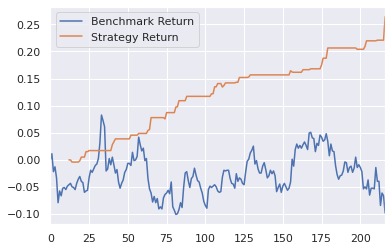

In [0]:
XYDataInformation_1
XYDataInformation_1[['Benchmark Return','Strategy Return']].plot()



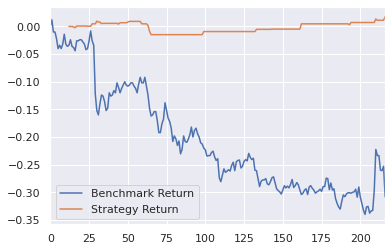

In [0]:
XYDataInformation_2
XYDataInformation_2[['Benchmark Return','Strategy Return']].plot()

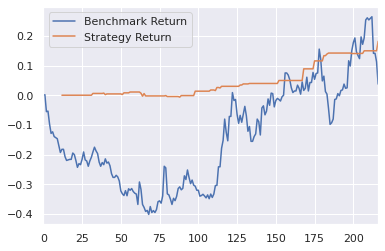

In [0]:
XYDataInformation_3
XYDataInformation_3[['Benchmark Return','Strategy Return']].plot()

In [0]:
startdate = '20180101'
enddate = get_today()
HSI = GetData('^HSI',Startdate=startdate,Enddate=enddate,LabelName='HSI Index')
HSI_DataInformation = HSI.DownloadData()

Data has already been downloaded from yahoo !
Information : 
 Name : ^HSI 
 Columns :  ['Name', 'TradeDate', 'IndexTradeDate', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'] 
 Total index  544 
 Saved Path in csv:  /content/DataBase/Csv/HSI Index.csv 
 Saved Path in excel: /content/DataBase/Xlsx/HSI Index.xlsx


In [0]:
Rf = 1.083/100
Weights = 1/3

XYD1_R = XYDataInformation_1[['TradeDate',' 中國平安 Close']]
XYD2_R= XYDataInformation_2[['TradeDate',' 大新金融 Close']]
XYD3_R= XYDataInformation_2[['TradeDate',' 瑞聲科技 Close']]

Close_Max = HSI_DataInformation['Close'].max()
Close_Min = HSI_DataInformation['Close'].min()
HSI_DataInformation['Close Normalization'] = np.nan
for i in range(len(HSI_DataInformation)):
  HSI_DataInformation['Close Normalization'][i] = (HSI_DataInformation['Close'][i] - Close_Max)/(Close_Max - Close_Min)
HSI_DataInformation['Volatility'] = HSI_DataInformation['Close Normalization'].rolling(252).std()
HSI_Return = (HSI_DataInformation['Close'][-1]/HSI_DataInformation['Close'][0]-1) /542 *252

HSI_Volatility = HSI_DataInformation['Volatility'].mean()


HSI_MatchData = HSI_DataInformation[HSI_DataInformation['TradeDate']>=XYD1_R['TradeDate'][0]]
HSI_MatchData.reset_index(inplace=True)



XYD1_R['中國平安 Close Normalization'] = np.nan
XYD2_R['大新金融 Close Normalization'] = np.nan
XYD3_R['瑞聲科技 Close Normalization'] = np.nan


XYD1_PMAX = XYD1_R[' 中國平安 Close'].max()
XYD1_PMIN = XYD1_R[' 中國平安 Close'].min()

XYD2_PMAX = XYD2_R[' 大新金融 Close'].max()
XYD2_PMIN = XYD2_R[' 大新金融 Close'].min()

XYD3_PMAX = XYD3_R[' 瑞聲科技 Close'].max()
XYD3_PMIN = XYD3_R[' 瑞聲科技 Close'].min()

for i in range(len(XYD1_R)):
  XYD1_R['中國平安 Close Normalization'][i] = (XYD1_R[' 中國平安 Close'][i] - XYD1_PMAX)/(XYD1_PMAX - XYD1_PMIN)
  XYD2_R['大新金融 Close Normalization'][i] = (XYD2_R[' 大新金融 Close'][i] - XYD2_PMAX)/(XYD2_PMAX - XYD2_PMIN)
  XYD3_R['瑞聲科技 Close Normalization'][i] = (XYD3_R[' 瑞聲科技 Close'][i] - XYD3_PMAX)/(XYD3_PMAX - XYD3_PMIN)

XYD1_R['Volatility'] = XYD1_R['中國平安 Close Normalization'].rolling(10).std()
XYD2_R['Volatility'] = XYD2_R['大新金融 Close Normalization'].rolling(10).std()
XYD3_R['Volatility'] = XYD3_R['瑞聲科技 Close Normalization'].rolling(10).std()

XYD1_R_Volatility = XYD1_R['Volatility'].mean()
XYD2_R_Volatility = XYD2_R['Volatility'].mean()
XYD3_R_Volatility = XYD3_R['Volatility'].mean()

XYD1_R_Return = XYDataInformation_1['Strategy Return'].iloc[-1]
XYD2_R_Return = XYDataInformation_2['Strategy Return'].iloc[-1]
XYD3_R_Return = XYDataInformation_3['Strategy Return'].iloc[-1]


Cor_XY123 = XYD1_R[['TradeDate','中國平安 Close Normalization']]
Cor_XY123 = pd.merge(Cor_XY123,XYD2_R[['TradeDate','大新金融 Close Normalization']])
Cor_XY123 = pd.merge(Cor_XY123,XYD3_R[['TradeDate','瑞聲科技 Close Normalization']])
Cor_XY123 = pd.merge(Cor_XY123,HSI_MatchData[['TradeDate','Close Normalization']])
CorData = Cor_XY123[['中國平安 Close Normalization','大新金融 Close Normalization','瑞聲科技 Close Normalization']].corr()


CovData = XYD1_R[['TradeDate',' 中國平安 Close']]
CovData = pd.merge(CovData,XYD2_R[['TradeDate',' 大新金融 Close']])
CovData = pd.merge(CovData,XYD3_R[['TradeDate',' 瑞聲科技 Close']])
CovData = pd.merge(CovData,HSI_MatchData[['TradeDate','Close']])

CovData['中國平安 Return'] = CovData[' 中國平安 Close']/CovData[' 中國平安 Close'].shift(1)
CovData['中國平安 Return'][0] = 1

CovData['大新金融 Return'] = CovData[' 大新金融 Close']/CovData[' 大新金融 Close'].shift(1)
CovData['大新金融 Return'][0] = 1

CovData['瑞聲科技 Return'] = CovData[' 瑞聲科技 Close']/CovData[' 瑞聲科技 Close'].shift(1)
CovData['瑞聲科技 Return'][0] = 1

CovData['HSI Return'] = CovData['Close']/CovData['Close'].shift(1)
CovData['HSI Return'][0] = 1

Cov = CovData[['中國平安 Return','大新金融 Return','瑞聲科技 Return','HSI Return']].cov()


Formula = Weights**2*XYD1_R_Volatility**2+Weights**2*XYD2_R_Volatility**2+Weights**2*XYD3_R_Volatility**2+2*Weights*Weights*CorData.iloc[0][1]*XYD1_R_Volatility*XYD2_R_Volatility+2*Weights*Weights*CorData.iloc[0][2]*XYD1_R_Volatility*XYD3_R_Volatility+2*Weights*Weights*CorData.iloc[1][2]*XYD2_R_Volatility*XYD3_R_Volatility

HSI_Return_Volatility = np.std(CovData['HSI Return'])
XY1_Beta = Cov.iloc[0][3]/(np.power(HSI_Return_Volatility,2))
XY2_Beta = Cov.iloc[1][3]/(np.power(HSI_Return_Volatility,2))
XY3_Beta = Cov.iloc[2][3]/(np.power(HSI_Return_Volatility,2))
Portfolio_Beta = Weights*(XY1_Beta+XY2_Beta+XY3_Beta)

Return_Portfolio = Weights * (XYD1_R_Return + XYD2_R_Return + XYD3_R_Return)
Volatility_Portfolio = np.sqrt(Formula)
Sharpe_Ratio = round((Return_Portfolio - Rf)/Volatility_Portfolio,2)
Jenson_Alpha = Return_Portfolio - (Rf + Portfolio_Beta*(HSI_Return-Rf))



In [0]:
print('Back Test Framework--------')
print('The Sharpe Ratio is %.2f.'%Sharpe_Ratio)
print('The Beta is %.2f.'%Portfolio_Beta)
print("The Jenson's Alpha is %.2f"%(Jenson_Alpha*100),"%.")
print('Net Income is $',Net_Income_1+Net_Income_2+Net_Income_3,'.')
print('Net Return is %.2f'%((Net_Income_1+Net_Income_2+Net_Income_3)/(Cash*3)*100),'%.')


Back Test Framework--------
The Sharpe Ratio is 4.27.
The Beta is 1.05.
The Jenson's Alpha is 27.13 %.
Net Income is $ 463200.09 .
Net Return is 15.44 %.
